# Generate financial time series (FTS) data

In [10]:
import os
import re
import sys
import json
import warnings
import matplotlib
import subprocess
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms

from tqdm import tqdm
from scipy.stats import norm
from functools import partial
from math import log10, floor
from scipy.optimize import curve_fit
from scipy.stats import percentileofscore
from multiprocessing import Pool, cpu_count

sys.path.append('../modules')
import plot_optimal_window as plt_ow
import estimate_optimal_window as eow
import get_financial_time_series as get_fts
import plot_temporal_fluctuation_scaling as plt_tfs
import estimate_temporal_fluctuation_scaling as etfs

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "olive", "gray", "cyan"]

In [11]:
%matplotlib inline

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2023-11-07"
max_date_1 = "2008-07-01"
max_date_2 = "2020-03-01"
max_date_3 = "2023-04-12" #input_generation_date

In [3]:
list_tickers = {
    "^GSPC" : "Standard and Poor's 500", # S&P 500 (United States)
    "^DJI" : "Dow Jones Industrial Average", # Dow Jones Industrial Average (United States)
    "^N225" : "Nikkei Heikin Kabuka Stock Exchange 225", # Nikkei 225 (Japan)
    "^BVSP" : "Sao Paulo Stock Exchange", # IBOVESPA (Brazil)
    "GBPUSD=X" : "Currency exchange rate from U.K. pound sterling to U.S. dollar", # GBP/USD
    "CHFUSD=X" : "Currency exchange rate from swiss franc to U.S. dollar", # CHF/USD
    "EURUSD=X" : "Currency exchange rate from euro to U.S. dollar", # EUR/USD
    "COP=X" : "Currency exchange rate from U.S. dollar to colombian peso" # USD/COP
}

In [4]:
df_derivatives = get_fts.load_financial_time_series(
    ticker_dict = list_tickers,
    initial_date = "1900-01-01",
    final_date = max_date_3,
    interval = "1d"
)

[*********************100%***********************]  1 of 1 completed
- Download ^GSPC with initial 23933 rows and 23619 rows after profiling
- Processed ^GSPC : Standard and Poor's 500
[*********************100%***********************]  1 of 1 completed
- Download ^DJI with initial 7877 rows and 7866 rows after profiling
- Processed ^DJI : Dow Jones Industrial Average
[*********************100%***********************]  1 of 1 completed
- Download ^N225 with initial 14329 rows and 14132 rows after profiling
- Processed ^N225 : Nikkei Heikin Kabuka Stock Exchange 225
[*********************100%***********************]  1 of 1 completed
- Download ^BVSP with initial 7414 rows and 7394 rows after profiling
- Processed ^BVSP : Sao Paulo Stock Exchange
[*********************100%***********************]  1 of 1 completed
- Download GBPUSD=X with initial 5035 rows and 5012 rows after profiling
- Processed GBPUSD=X : Currency exchange rate from U.K. pound sterling to U.S. dollar
[***************

## Mean and variance evolution

We have these theoretical equations: 
$$\mu(t)=r_{x}+c_{1}t+b\ln{(1+t)}$$
$$\Upsilon(t)=c_{2}t-c_{1}b t\ln{(1+t)}-r_{x}b\ln{(1+t)}-b^{2}\ln^{2}{(1+t)}$$

In [5]:
df_derivatives_parameters_0 = eow.estimate_mean_variance_parameters(
    df_fts = df_derivatives,
    drift_params_degree = 0,
    minimal_points = 20,
    p_norm = 1,
    log_path = log_path,
    log_filename = "log_aesepelt_derivative_0_{}".format(re.sub("-", "", input_generation_date)),
    verbose = 1,
    tqdm_bar = True
)

100%|███████████████████| 3581/3581 [02:35<00:00, 22.99it/s]


In [5]:
df_derivatives_parameters_1 = eow.estimate_mean_variance_parameters(
    df_fts = df_derivatives[df_derivatives["date"] <= max_date_1],
    drift_params_degree = 0,
    minimal_points = 20,
    p_norm = 1,
    log_path = log_path,
    log_filename = "log_aesepelt_derivative_1_{}".format(re.sub("-", "", input_generation_date)),
    verbose = 1,
    tqdm_bar = True
)

100%|███████████████████| 1370/1370 [05:48<00:00,  3.93it/s]


In [6]:
A = df_derivatives[((df_derivatives["date"] >= max_date_1) & (df_derivatives["date"] <= max_date_2))]
A["step"] = A.groupby(["symbol"])["step"].transform(lambda x: x - np.min(x))
df_derivatives_parameters_2 = eow.estimate_mean_variance_parameters(
    df_fts = A,
    drift_params_degree = 0,
    minimal_points = 20,
    p_norm = 1,
    log_path = log_path,
    log_filename = "log_aesepelt_derivative_2_{}".format(re.sub("-", "", input_generation_date)),
    verbose = 1,
    tqdm_bar = True
)

100%|█████████████████████| 747/747 [02:04<00:00,  6.01it/s]


In [7]:
A = df_derivatives[df_derivatives["date"] >= max_date_2]
A["step"] = A.groupby(["symbol"])["step"].transform(lambda x: x - np.min(x))
df_derivatives_parameters_3 = eow.estimate_mean_variance_parameters(
    df_fts = A,
    drift_params_degree = 0,
    minimal_points = 20,
    p_norm = 1,
    log_path = log_path,
    log_filename = "log_aesepelt_derivative_3_{}".format(re.sub("-", "", input_generation_date)),
    verbose = 1,
    tqdm_bar = True
)

100%|█████████████████████| 213/213 [00:17<00:00, 12.48it/s]


## Optimal window resume

In [6]:
df_optimal_derivatives_0 = eow.estimate_optimal_window(df_fts_parameters = df_derivatives_parameters_0)
df_optimal_derivatives_0

symbol  window_size_mean  drift_degree  step_mean  \
0   CHFUSD=X               253             0       5060   
1   CHFUSD=X               227             0       4994   
2   CHFUSD=X               253             0       5060   
3      COP=X               194             0       4850   
4      COP=X               239             0       5019   
5      COP=X               216             0       4968   
6   EURUSD=X               244             0       4880   
7   EURUSD=X               218             0       5014   
8   EURUSD=X               244             0       4880   
9   GBPUSD=X               250             0       5000   
10  GBPUSD=X                 5             0       5030   
11  GBPUSD=X               250             0       5000   
12     ^BVSP                 1             0       7412   
13     ^BVSP                 1             0       7412   
14     ^BVSP               365             0       7300   
15      ^DJI               378             0       7560   
16      ^DJI               342             0       7866   
17      ^DJI               393             0       7860   
18     ^GSPC               914             0      23764   
19     ^GSPC               771             0      23901   
20     ^GSPC               914             0      23764   
21     ^N225               706             0      14120   
22     ^N225               586             0      14064   
23     ^N225               706             0      14120   

              time_series  p_norm  cumulant_1_mean  error_cumulant_1_mean  \
0     absolute log-return       1    -6.246120e-07           8.029159e-08   
1              log-return       1    -5.513647e-08           9.098323e-09   
2   log-return volatility       1    -3.529133e-04           4.662844e-05   
3     absolute log-return       1     6.689454e-06           9.460444e-07   
4              log-return       1     1.774711e-07           1.658956e-08   
5   log-return volatility       1    -3.454296e-06           5.532072e-07   
6     absolute log-return       1    -5.274014e-07           6.556239e-08   
7              log-return       1    -4.361124e-08           6.602317e-09   
8   log-return volatility       1    -3.697809e-04           4.409019e-05   
9     absolute log-return       1    -4.005629e-07           6.685228e-08   
10             log-return       1     8.426879e-08           4.987519e-09   
11  log-return volatility       1    -7.099279e-04           9.380306e-05   
12    absolute log-return       1    -1.010914e-06           1.881160e-08   
13             log-return       1     5.472098e-07           1.649775e-08   
14  log-return volatility       1    -2.399518e-04           3.462043e-05   
15    absolute log-return       1     6.606349e-08           6.244535e-08   
16             log-return       1    -4.834087e-08           1.018046e-08   
17  log-return volatility       1    -1.506782e-04           2.083693e-05   
18    absolute log-return       1    -4.196535e-07           5.799066e-08   
19             log-return       1     1.377674e-08           2.091180e-09   
20  log-return volatility       1    -7.425574e-05           9.010689e-06   
21    absolute log-return       1     5.828278e-08           5.143797e-08   
22             log-return       1    -4.181476e-08           4.156655e-09   
23  log-return volatility       1    -6.143171e-05           1.087665e-05   

    tfs_param_mean  error_tfs_param_mean  drift_coefficient_0_mean  \
0     8.527576e-04              0.000068                  0.000253   
1     3.608205e-05              0.000008                  0.000021   
2     6.399483e-01              0.039618                  0.187123   
3    -9.462526e-05              0.000829                  0.000524   
4    -7.579749e-05              0.000014                 -0.000051   
5     6.469037e-03              0.000483                  0.002253   
6     8.274112e-04              0.000053                  0.000061   
7     1.902773e-05              0.000006    

In [8]:
df_optimal_derivatives_1 = eow.estimate_optimal_window(df_fts_parameters = df_derivatives_parameters_1)
df_optimal_derivatives_1

symbol  window_size_mean  drift_degree  step_mean  \
0   CHFUSD=X                57             0       1197   
1   CHFUSD=X                 1             0       1240   
2   CHFUSD=X                57             0       1197   
3   EURUSD=X                59             0       1180   
4   EURUSD=X                59             0       1180   
5   EURUSD=X                59             0       1180   
6   GBPUSD=X                59             0       1180   
7   GBPUSD=X                45             0       1170   
8   GBPUSD=X                59             0       1180   
9       ^DJI               189             0       3969   
10      ^DJI               176             0       4048   
11      ^DJI               199             0       3980   
12     ^GSPC               914             0      20108   
13     ^GSPC               771             0      20046   
14     ^GSPC               914             0      20108   

              time_series  p_norm  cumulant_1_mean  error_cumulant_1_mean  \
0     absolute log-return       1    -4.058748e-06           4.187318e-07   
1              log-return       1     1.342261e-06           5.014340e-08   
2   log-return volatility       1    -2.059701e-03           2.071498e-04   
3     absolute log-return       1    -3.379369e-06           4.243937e-07   
4              log-return       1     4.680384e-08           1.612618e-07   
5   log-return volatility       1    -2.135102e-03           2.746855e-04   
6     absolute log-return       1    -3.211143e-06           4.026473e-07   
7              log-return       1    -4.283149e-07           2.100070e-07   
8   log-return volatility       1    -4.570193e-03           6.584283e-04   
9     absolute log-return       1     4.242673e-07           1.337362e-07   
10             log-return       1    -8.341989e-08           2.596787e-08   
11  log-return volatility       1    -3.346748e-04           5.759205e-05   
12    absolute log-return       1    -5.402594e-07           6.725243e-08   
13             log-return       1     1.753794e-08           2.532729e-09   
14  log-return volatility       1    -9.278275e-05           1.051864e-05   

    tfs_param_mean  error_tfs_param_mean  drift_coefficient_0_mean  \
0         0.001207              0.000100                  0.000519   
1        -0.000918              0.000018                  0.005178   
2         0.842877              0.049674                  0.255171   
3         0.001028              0.000099                  0.000450   
4        -0.000005              0.000038                  0.000119   
5         0.849898              0.064229                  0.303509   
6         0.000978              0.000094                  0.000437   
7         0.000020              0.000052                  0.000350   
8         1.882395              0.153960                  0.732962   
9         0.000682              0.000093                  0.000230   
10        0.000092              0.000019                 -0.000068   
11        0.743283              0.039499                  0.188441   
12        0.001634              0.000197                  0.000618   
13       -0.000005              0.000008                 -0.000030   
14        0.463210              0.030854                  0.120557   

    error_drift_coefficient_0_mean  average_error_mean  rsquared_mean  \
0                         0.000448            0.000335       0.884320   
1                         0.000086            0.000114       0.755791   
2                         0.221804            0.166918       0.941798   
3                         0.000441            0.000338       0.856295   
4                         0.000167            0.000111       0.005659   
5                         0.285136            0.224146       0.912018   
6                         0.000418            0.000318       0.857054   
7                         0.000234            0.000152       0.237161   
8                         0.683479            0.54

In [9]:
df_optimal_derivatives_2 = eow.estimate_optimal_window(df_fts_parameters = df_derivatives_parameters_2)
df_optimal_derivatives_2

symbol  window_size_mean  drift_degree  step_mean  \
0   CHFUSD=X                 1             0       3034   
1   CHFUSD=X               120             0       3000   
2   CHFUSD=X               137             0       3014   
3   EURUSD=X               150             0       3000   
4   EURUSD=X               111             0       2997   
5   EURUSD=X               124             0       2976   
6   GBPUSD=X               149             0       2980   
7   GBPUSD=X               119             0       2975   
8   GBPUSD=X               149             0       2980   
9       ^DJI               139             0       2919   
10      ^DJI               145             0       2900   
11      ^DJI               142             0       2840   
12     ^GSPC                 1             0       2935   
13     ^GSPC               145             0       2900   
14     ^GSPC               141             0       2820   

              time_series  p_norm  cumulant_1_mean  error_cumulant_1_mean  \
0     absolute log-return       1    -4.765603e-07           3.159444e-09   
1              log-return       1    -4.092940e-08           6.776935e-09   
2   log-return volatility       1    -7.902039e-05           5.934146e-06   
3     absolute log-return       1    -4.720106e-07           2.271100e-08   
4              log-return       1    -2.366410e-08           6.342487e-09   
5   log-return volatility       1    -1.300303e-04           4.668047e-06   
6     absolute log-return       1    -3.213027e-07           3.740944e-08   
7              log-return       1     5.576294e-09           8.362328e-09   
8   log-return volatility       1    -1.857584e-04           2.332418e-05   
9     absolute log-return       1    -3.473510e-07           1.734414e-08   
10             log-return       1     3.082019e-08           4.215134e-09   
11  log-return volatility       1    -4.392481e-05           4.744022e-06   
12    absolute log-return       1    -1.291741e-07           6.639425e-10   
13             log-return       1     1.250358e-08           1.168895e-09   
14  log-return volatility       1    -5.485440e-06           6.836287e-07   

    tfs_param_mean  error_tfs_param_mean  drift_coefficient_0_mean  \
0         0.000272          2.788442e-06                  0.004016   
1        -0.000005          3.850517e-06                  0.000242   
2         0.032290          3.266223e-03                  4.070098   
3         0.000210          1.211283e-05                  0.004436   
4        -0.000025          3.677275e-06                  0.000237   
5         0.057972          2.603567e-03                  4.188125   
6         0.000137          1.983398e-05                  0.004094   
7        -0.000022          4.715859e-06                  0.000096   
8         0.092688          1.236617e-02                  9.452028   
9         0.000138          9.155673e-06                  0.007048   
10       -0.000009          2.181444e-06                  0.000297   
11        0.030651          2.410002e-03                  5.165503   
12        0.000078          5.664588e-07                  0.007415   
13       -0.000002          6.049343e-07                  0.000213   
14        0.004191          3.451171e-04                  3.100193   

    error_drift_coefficient_0_mean  average_error_mean  rsquared_mean  \
0                         0.000016            0.000056       0.900647   
1                         0.000021            0.000015       0.823866   
2                         0.017351            0.013977       0.898708   
3                         0.000064            0.000043       0.960974   
4                         0.000020            0.000016       0.893225   
5                         0.013869            0.010936       0.972721   
6                         0.000105            0.000086       0.805923   
7                         0.000025            0.000019       0.629037   
8                         0.065174            0.05

In [10]:
df_optimal_derivatives_3 = eow.estimate_optimal_window(df_fts_parameters = df_derivatives_parameters_3)
df_optimal_derivatives_3

symbol  window_size_mean  drift_degree  step_mean  \
0   CHFUSD=X                 1             0        855   
1   CHFUSD=X                39             0        819   
2   CHFUSD=X                37             0        851   
3   EURUSD=X                 1             0        855   
4   EURUSD=X                 1             0        855   
5   EURUSD=X                 1             0        855   
6   GBPUSD=X                 1             0        855   
7   GBPUSD=X                 1             0        855   
8   GBPUSD=X                39             0        819   
9       ^DJI                40             0        800   
10      ^DJI                 1             0        825   
11      ^DJI                40             0        800   
12     ^GSPC                41             0        820   
13     ^GSPC                 1             0        825   
14     ^GSPC                40             0        800   

              time_series  p_norm  cumulant_1_mean  error_cumulant_1_mean  \
0     absolute log-return       1    -1.432160e-07           4.856917e-09   
1              log-return       1    -3.316099e-08           7.834428e-09   
2   log-return volatility       1    -4.784235e-05           3.872030e-06   
3     absolute log-return       1    -1.303457e-07           6.725016e-09   
4              log-return       1    -7.077274e-08           2.427694e-09   
5   log-return volatility       1    -7.849820e-06           1.408618e-06   
6     absolute log-return       1     1.428071e-08           7.875277e-09   
7              log-return       1    -5.991710e-08           2.745447e-09   
8   log-return volatility       1    -3.141997e-05           3.164012e-05   
9     absolute log-return       1    -7.317222e-08           3.791809e-08   
10             log-return       1    -6.196865e-08           2.724474e-09   
11  log-return volatility       1    -3.657885e-05           8.798220e-06   
12    absolute log-return       1     2.847893e-08           1.758376e-08   
13             log-return       1    -2.035364e-08           1.040490e-09   
14  log-return volatility       1    -7.336587e-07           2.117256e-06   

    tfs_param_mean  error_tfs_param_mean  drift_coefficient_0_mean  \
0        -0.000020          1.220341e-06                  0.004760   
1         0.000003          1.345876e-06                  0.000082   
2        -0.000704          7.031522e-04                  4.081435   
3        -0.000023          1.689824e-06                  0.004756   
4         0.000012          6.100171e-07                 -0.000055   
5        -0.009922          3.539498e-04                  4.304730   
6        -0.000012          1.979563e-06                  0.004413   
7         0.000015          6.901067e-07                 -0.000124   
8         0.003555          5.435460e-03                  9.684606   
9         0.000039          6.305936e-06                  0.007209   
10        0.000019          6.610925e-07                  0.000224   
11        0.009077          1.463182e-03                  5.302844   
12        0.000007          2.988109e-06                  0.007679   
13        0.000007          2.524745e-07                  0.000199   
14        0.000886          3.521097e-04                  3.119310   

    error_drift_coefficient_0_mean  average_error_mean  rsquared_mean  \
0                         0.000005            0.000015       0.909252   
1                         0.000006            0.000004       0.518292   
2                         0.002939            0.002349       0.953410   
3                         0.000007            0.000021       0.837356   
4                         0.000003            0.000007       0.538400   
5                         0.001548            0.004209       0.844725   
6                         0.000009            0.000024       0.088798   
7                         0.000003            0.000008       0.370769   
8                         0.022423            0.01

In [7]:
if os.path.exists("{}/{}".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}".format(output_path, re.sub("-", "", input_generation_date)))
if os.path.exists("{}/{}/aesepelt".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}/aesepelt".format(output_path, re.sub("-", "", input_generation_date)))

Generated plot for ^GSPC and time series absolute log-return
Generated plot for ^GSPC and time series log-return
Generated plot for ^GSPC and time series log-return volatility


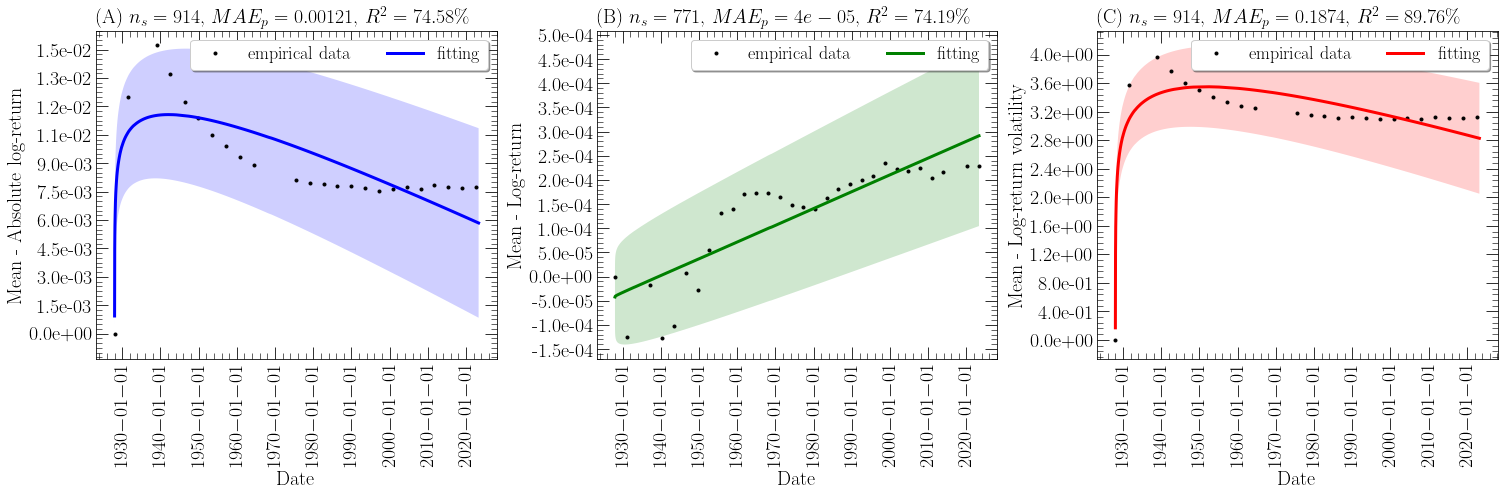

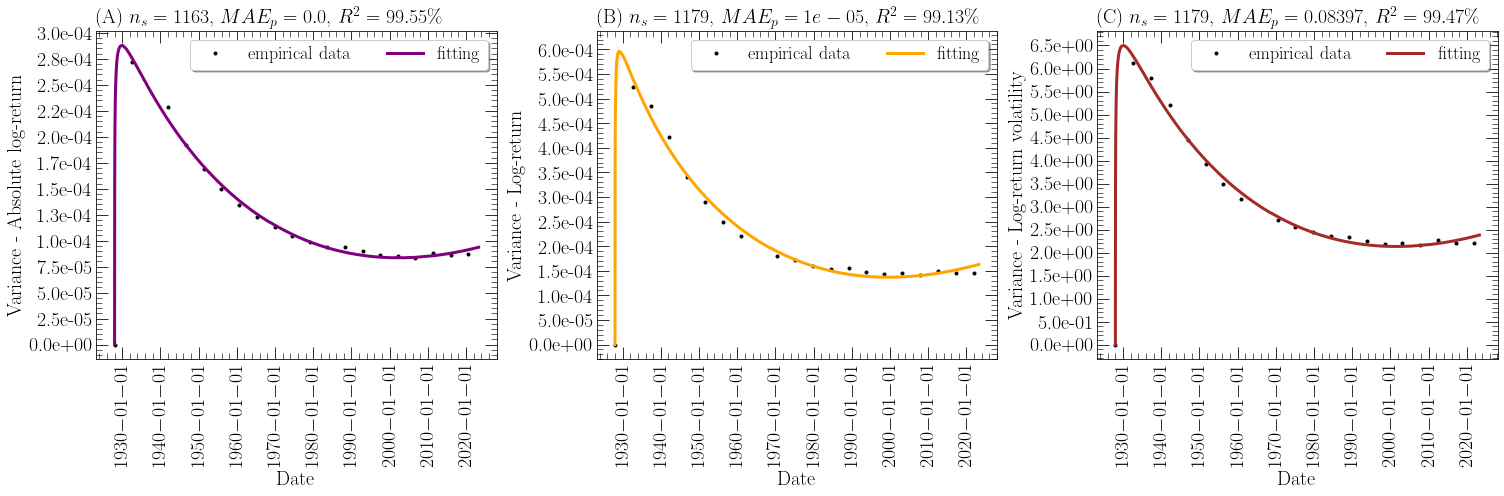

Generated plot for ^DJI and time series absolute log-return
Generated plot for ^DJI and time series log-return
Generated plot for ^DJI and time series log-return volatility


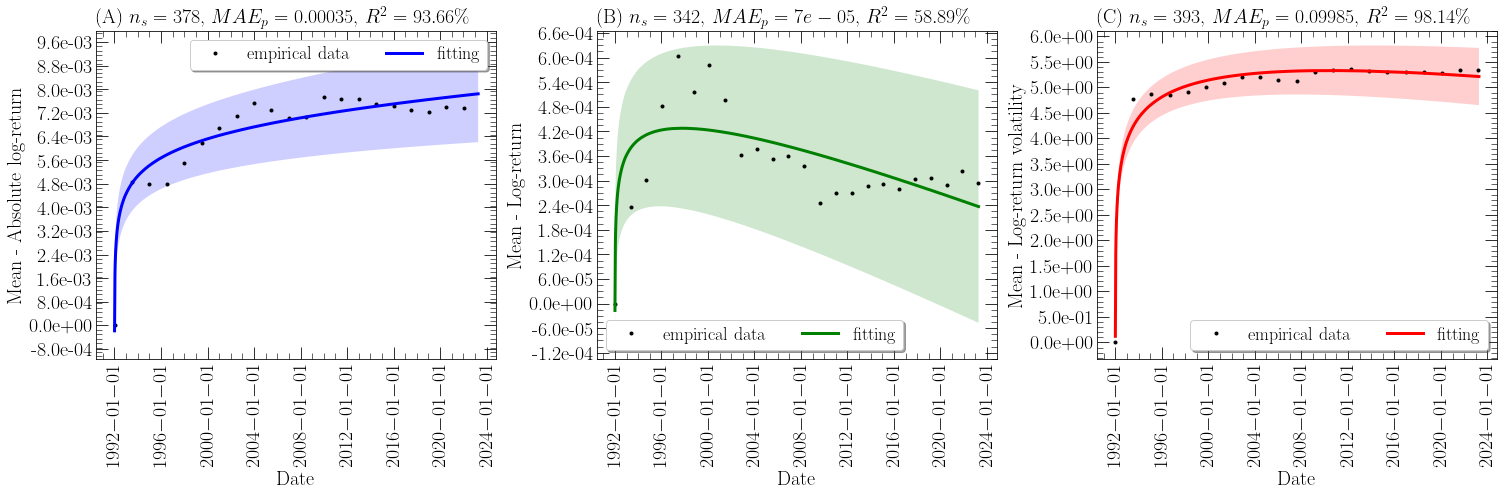

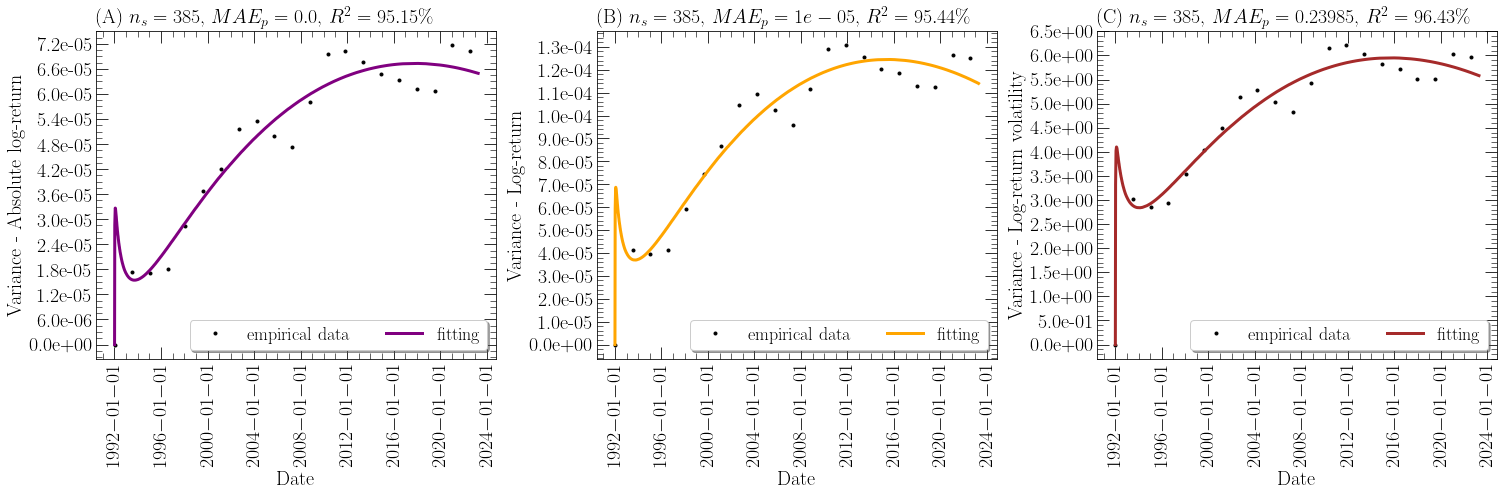

Generated plot for ^N225 and time series absolute log-return
Generated plot for ^N225 and time series log-return
Generated plot for ^N225 and time series log-return volatility


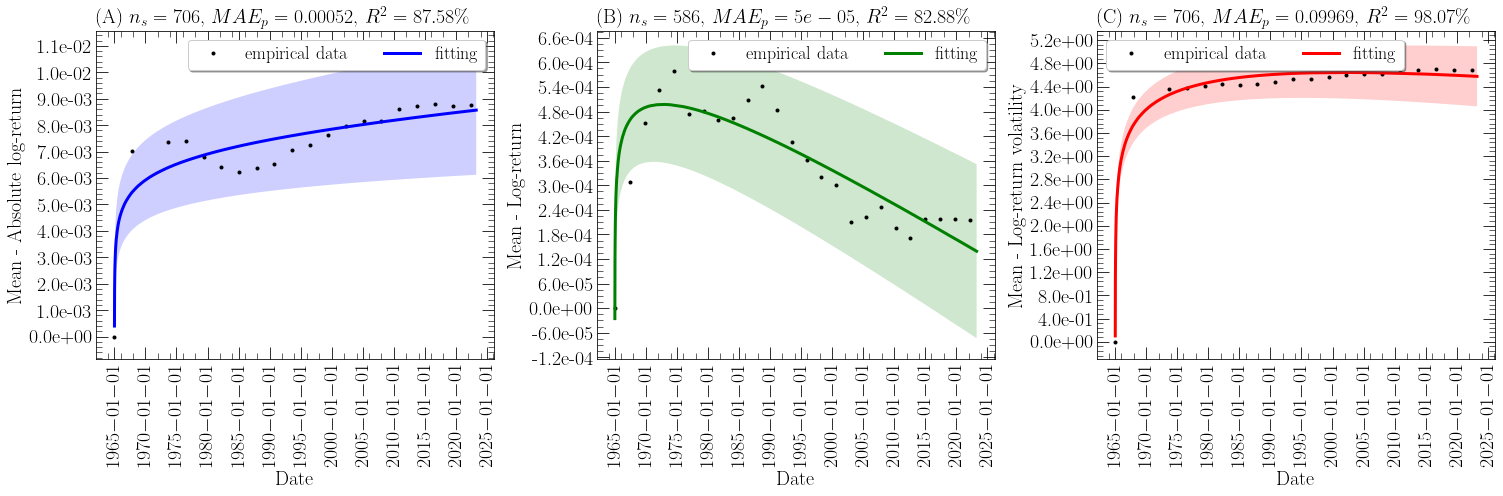

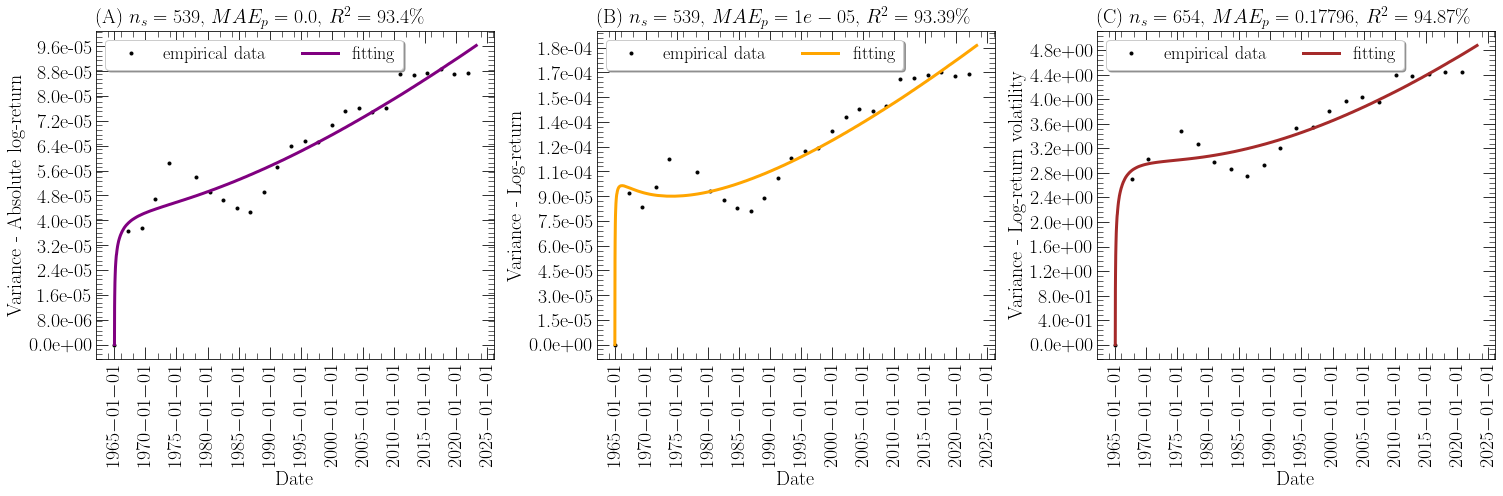

Generated plot for ^BVSP and time series absolute log-return
Generated plot for ^BVSP and time series log-return
Generated plot for ^BVSP and time series log-return volatility


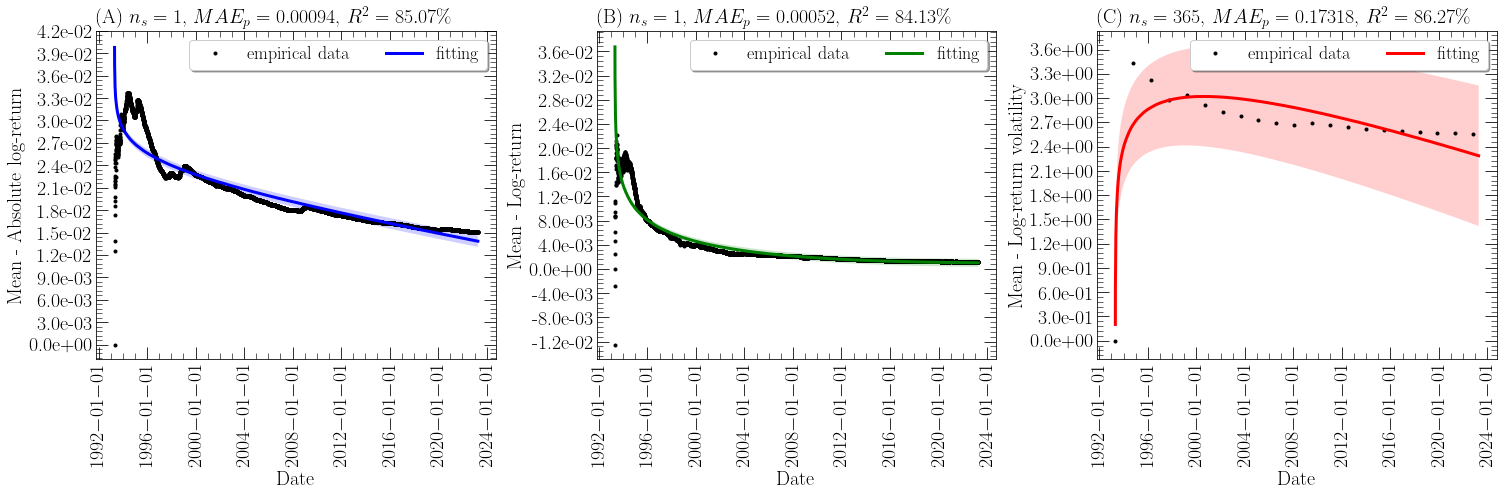

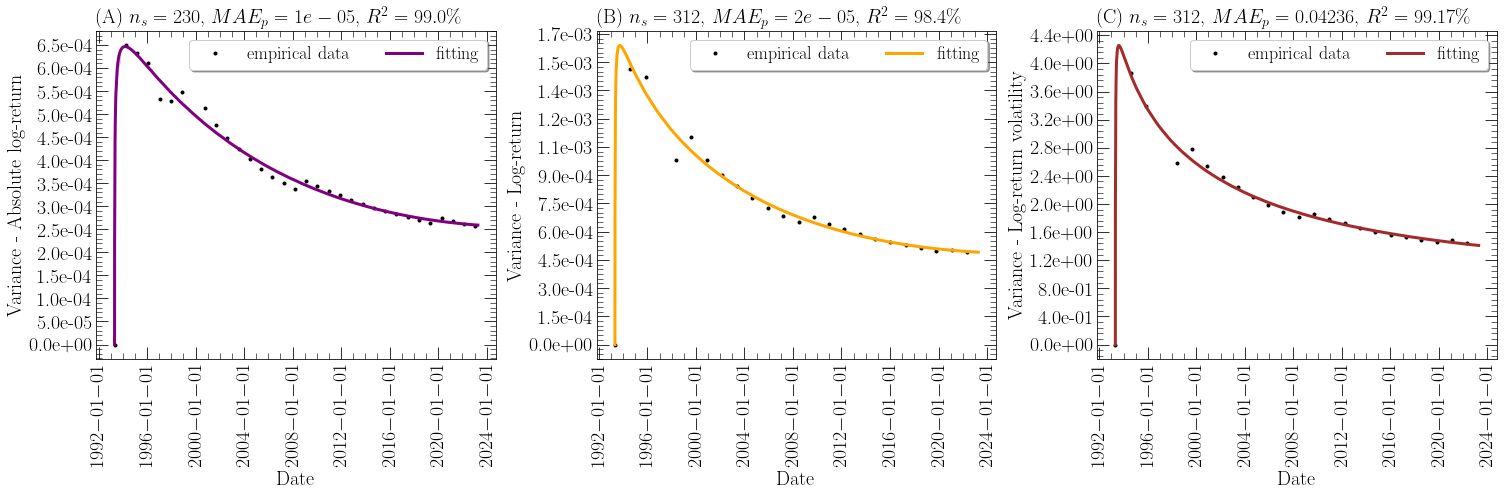

Generated plot for GBPUSD=X and time series absolute log-return
Generated plot for GBPUSD=X and time series log-return
Generated plot for GBPUSD=X and time series log-return volatility


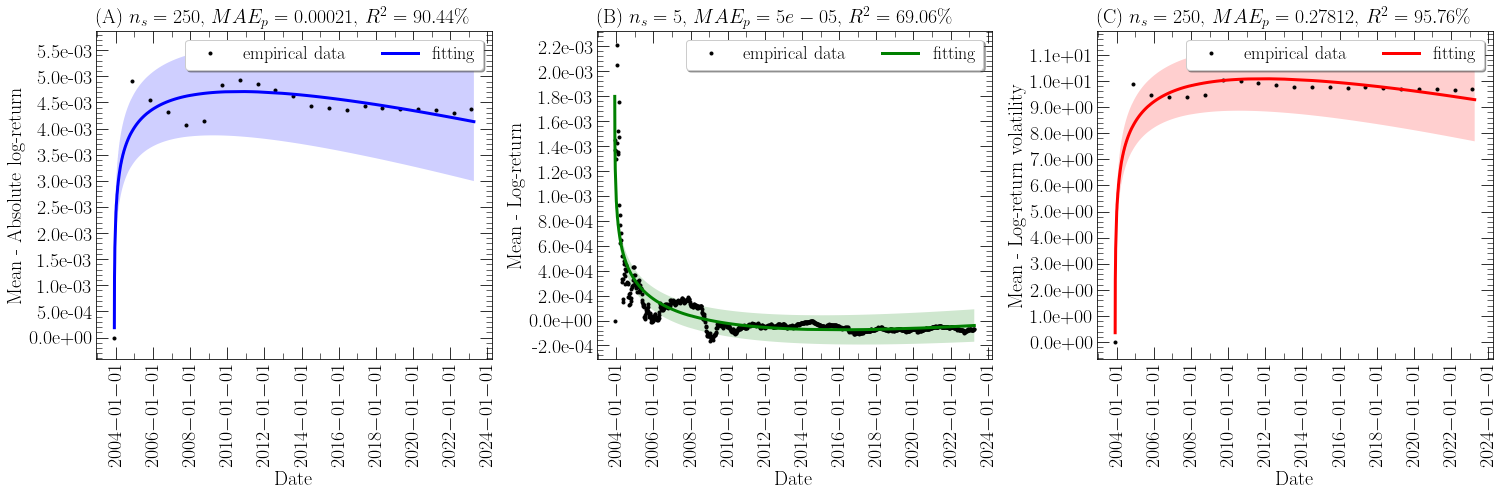

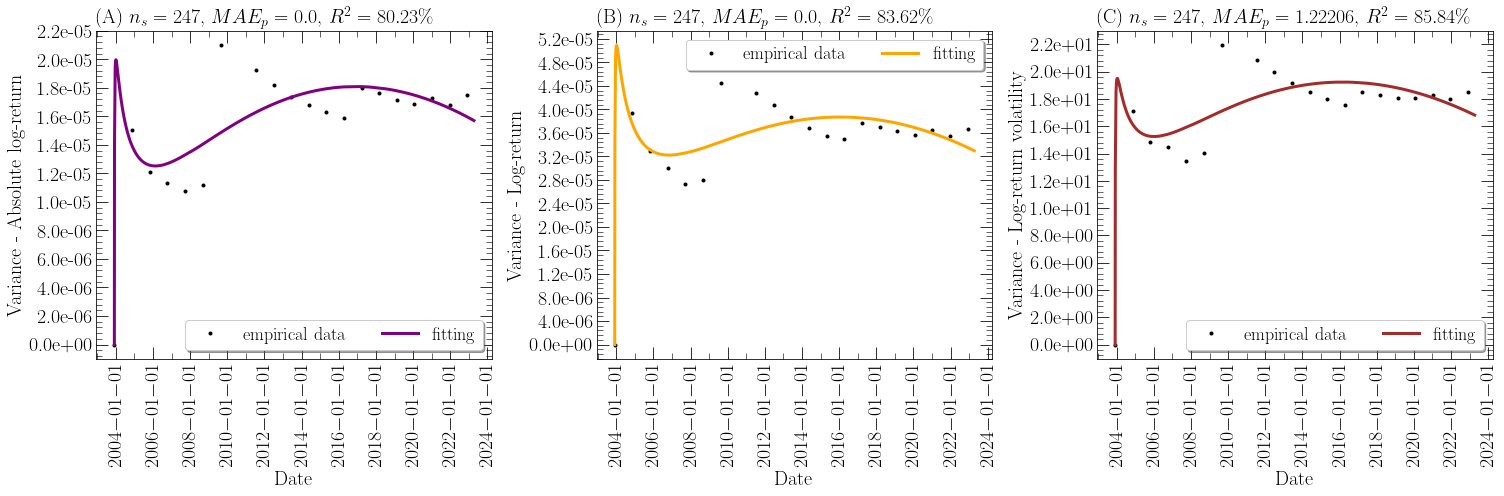

Generated plot for CHFUSD=X and time series absolute log-return
Generated plot for CHFUSD=X and time series log-return
Generated plot for CHFUSD=X and time series log-return volatility


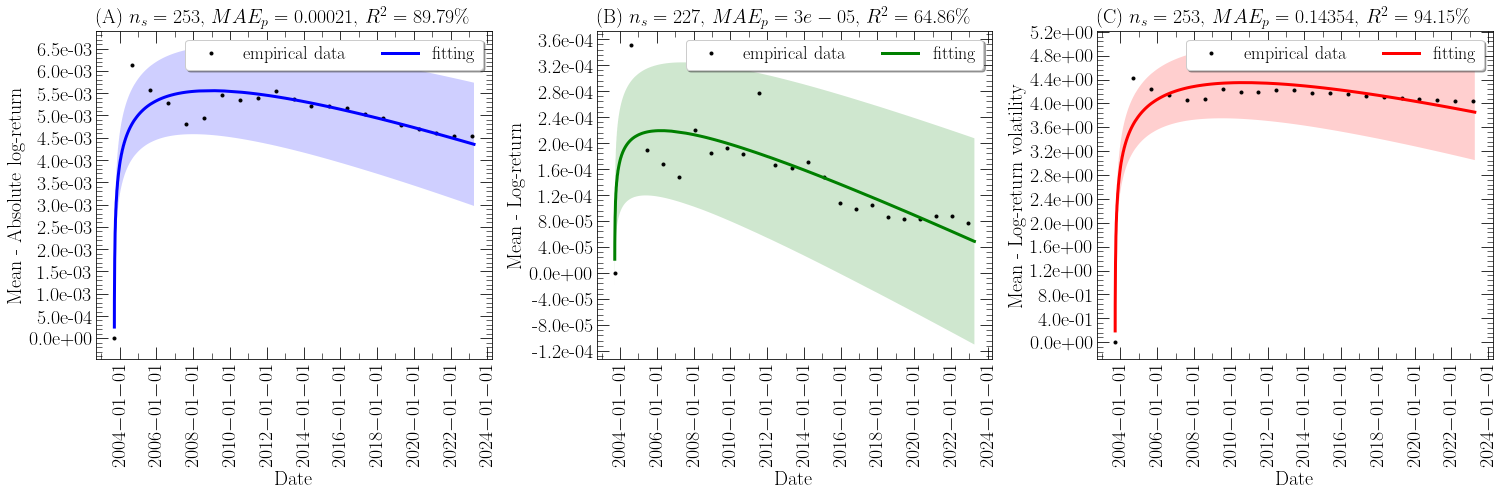

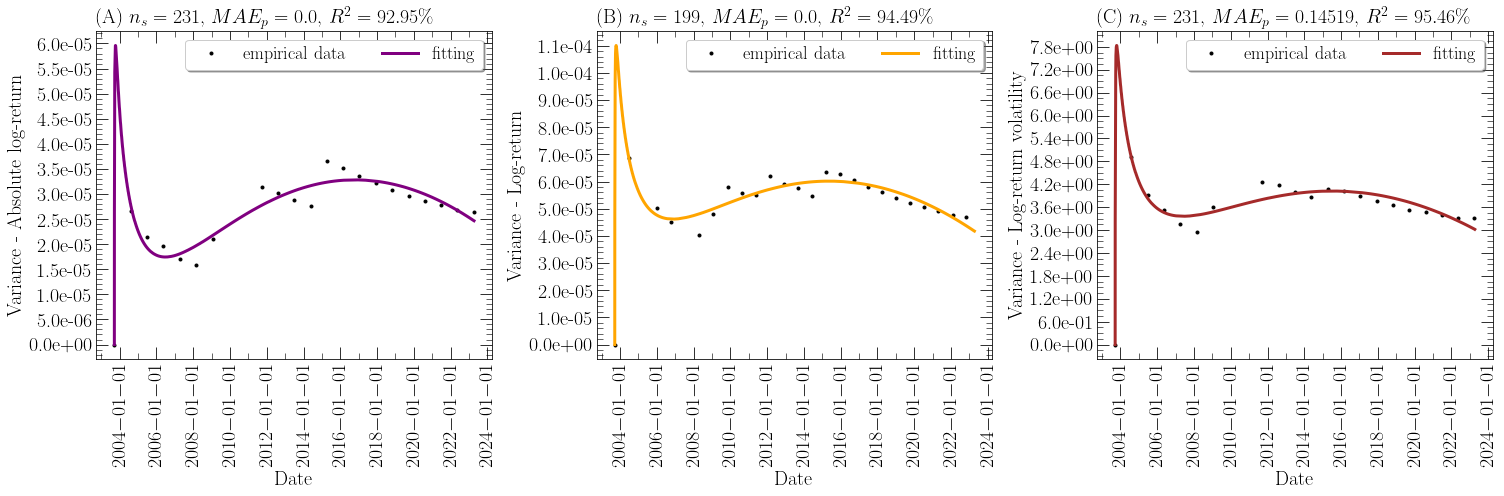

Generated plot for EURUSD=X and time series absolute log-return
Generated plot for EURUSD=X and time series log-return
Generated plot for EURUSD=X and time series log-return volatility


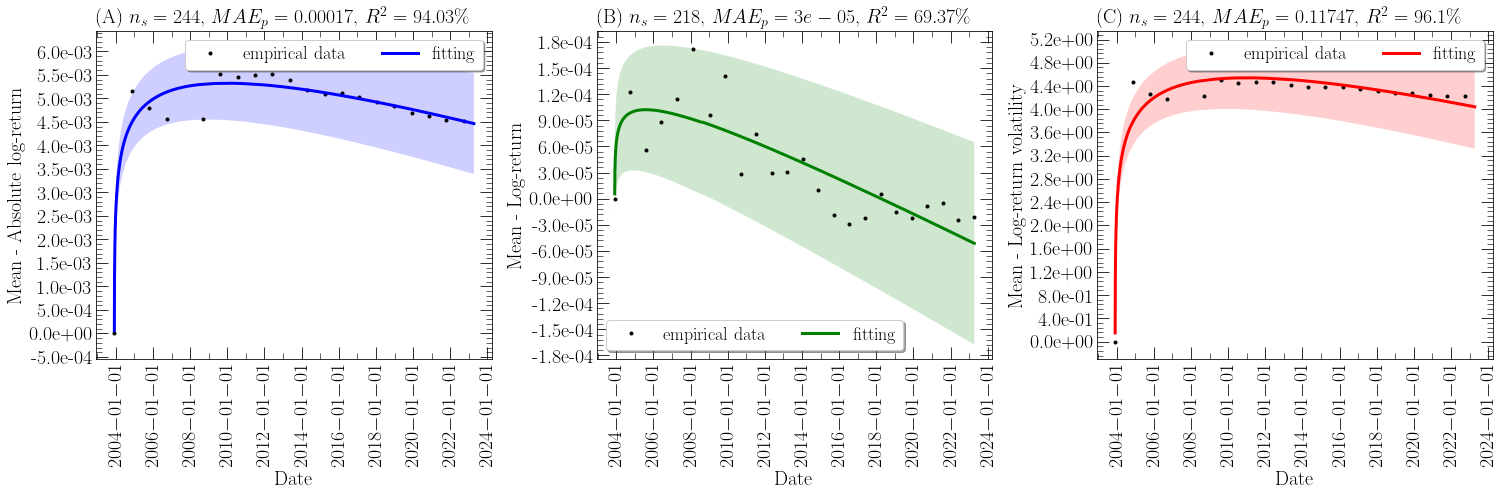

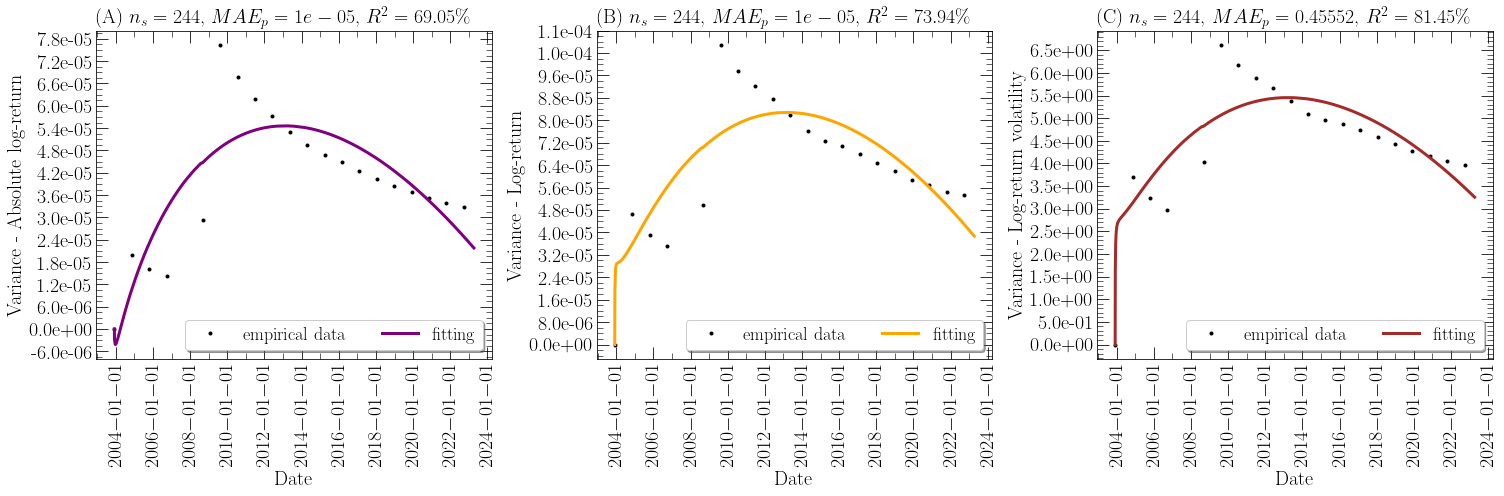

Generated plot for COP=X and time series absolute log-return
Generated plot for COP=X and time series log-return
Generated plot for COP=X and time series log-return volatility


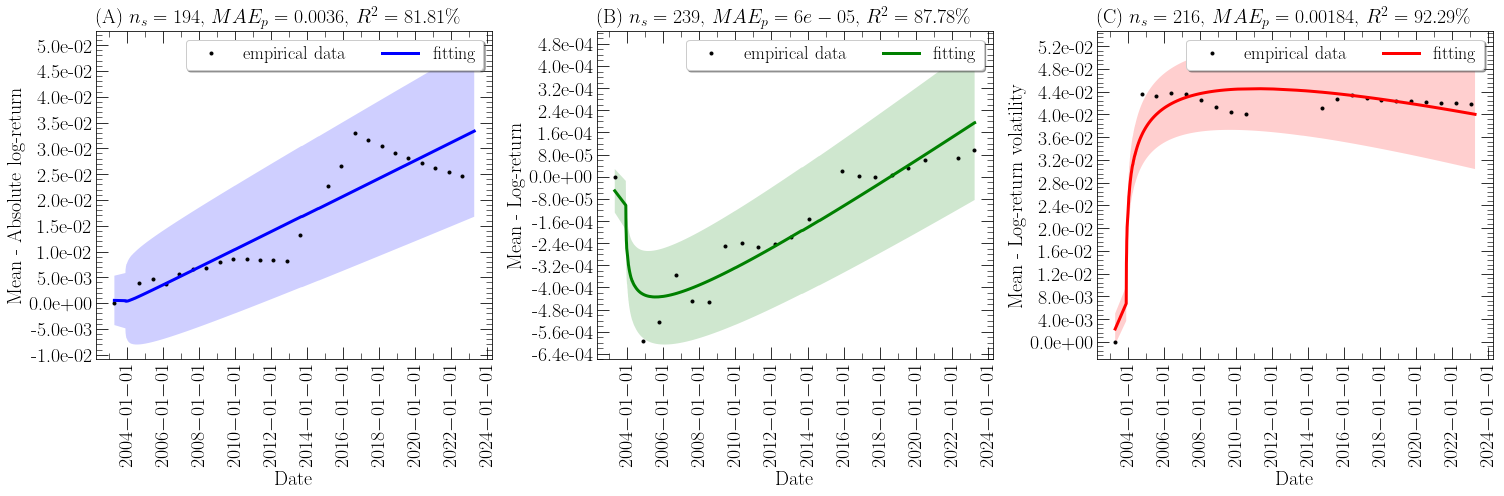

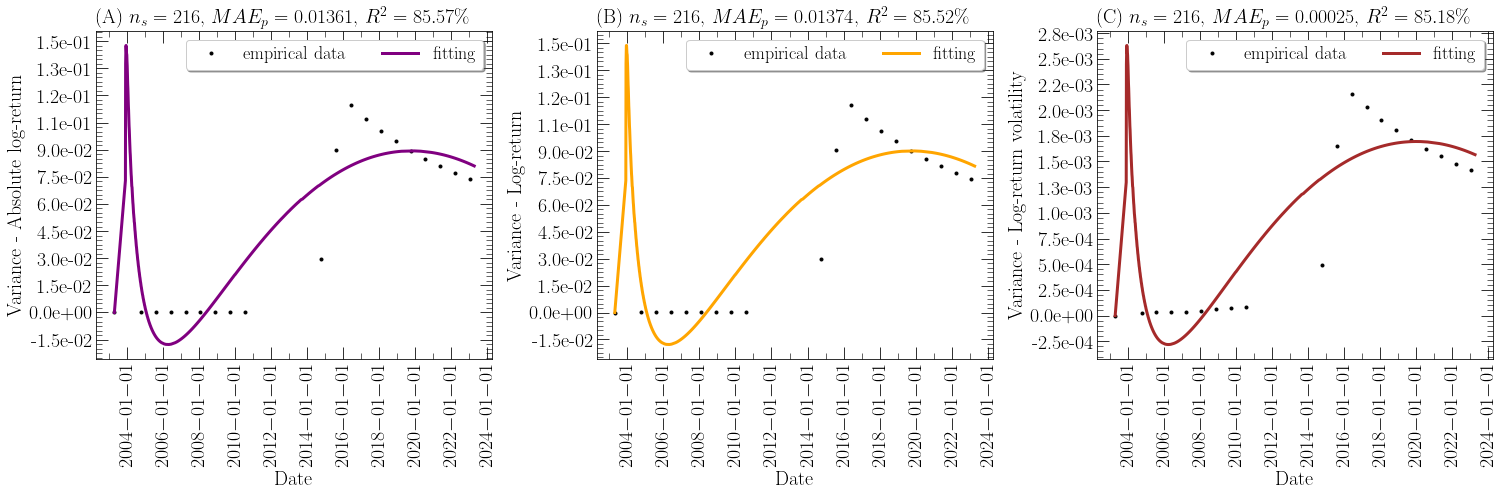

In [8]:
for ticker, ticker_name in list_tickers.items():
    df_graph = plt_ow.plot_optimal_window(
        df_fts = df_derivatives,
        df_optimal = df_optimal_derivatives_0,
        interval = "days",
        symbols = [ticker],
        width = 21,
        height = 7,
        all_data = False,
        markersize = 3,
        fontsize_labels = 20,
        fontsize_legend = 18,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 15,
        n_y_breaks = 15,
        fancy_legend = True,
        dpi = 900,
        save_figures = True,
        output_path = "{}/{}/aesepelt".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = "{}_0".format(re.sub("(\^)|(=X)", "", ticker)),
        input_generation_date = input_generation_date
    )

In [9]:
plt_ow.resume_optimal_window(
    df_optimal = df_optimal_derivatives_0,
    symbols_order = list_tickers,
    precision = 3,
    output_path = "{}/{}/aesepelt".format(output_path, re.sub("-", "", input_generation_date)),
    input_generation_date = input_generation_date
)[0]

symbol            time_series  cumulant_1_mean_om_min  \
0   CHFUSD=X    absolute log-return                      -6   
1   CHFUSD=X             log-return                      -6   
2   CHFUSD=X  log-return volatility                      -6   
3      COP=X    absolute log-return                      -6   
4      COP=X             log-return                      -6   
5      COP=X  log-return volatility                      -6   
6   EURUSD=X    absolute log-return                      -6   
7   EURUSD=X             log-return                      -6   
8   EURUSD=X  log-return volatility                      -6   
9   GBPUSD=X    absolute log-return                      -6   
10  GBPUSD=X             log-return                      -6   
11  GBPUSD=X  log-return volatility                      -6   
12     ^BVSP    absolute log-return                      -6   
13     ^BVSP             log-return                      -6   
14     ^BVSP  log-return volatility                      -6   
15      ^DJI    absolute log-return                      -6   
16      ^DJI             log-return                      -6   
17      ^DJI  log-return volatility                      -6   
18     ^GSPC    absolute log-return                      -6   
19     ^GSPC             log-return                      -6   
20     ^GSPC  log-return volatility                      -6   
22     ^N225             log-return                      -6   
21     ^N225    absolute log-return                      -6   
23     ^N225  log-return volatility                      -6   

    tfs_param_mean_om_min  drift_coefficient_0_mean_om_min  \
0                      -5                               -4   
1                      -5                               -4   
2                      -5                               -4   
3                      -5                               -4   
4                      -5                               -4   
5                      -5                               -4   
6                      -5                               -4   
7                      -5                               -4   
8                      -5                               -4   
9                      -5                               -4   
10                     -5                               -4   
11                     -5                               -4   
12                     -5                               -4   
13                     -5                               -4   
14                     -5                               -4   
15                     -5                               -4   
16                     -5                               -4   
17                     -5                               -4   
18                     -5                               -4   
19                     -5                               -4   
20                     -5                               -4   
22                     -5                               -4   
21                     -5                               -4   
23                     -5                               -4   

    average_error_mean_om_min           Cumulant 1            TFS amplitude  \
0                          -3     $-0.625\pm0.080$         $85.276\pm6.822$   
1                          -3     $-0.055\pm0.009$          $3.608\pm0.786$   
2                          -3  $-352.913\pm46.628$   $63994.829\pm3961.785$   
3                          -3      $6.689\pm0.946$        $-9.463\pm82.850$   
4                          -3      $0.177\pm0.017$         $-7.580\pm1.374$   
5                          -3     $-3.454\pm0.553$       $646.904\pm48.313$   
6                          -3     $-0.527\pm0.066$         $82.741\pm5.265$   
7                          -3     $-0.044\pm0.007$          $1.903\pm0.580$   
8                          -3  $-369.781\pm44.090$   $67460.928\pm3540.455$   
9                          -3     $-0.401\pm0.067$         $69.932\pm5.620$   
10        

Generated plot for ^GSPC and time series absolute log-return
Generated plot for ^GSPC and time series log-return
Generated plot for ^GSPC and time series log-return volatility


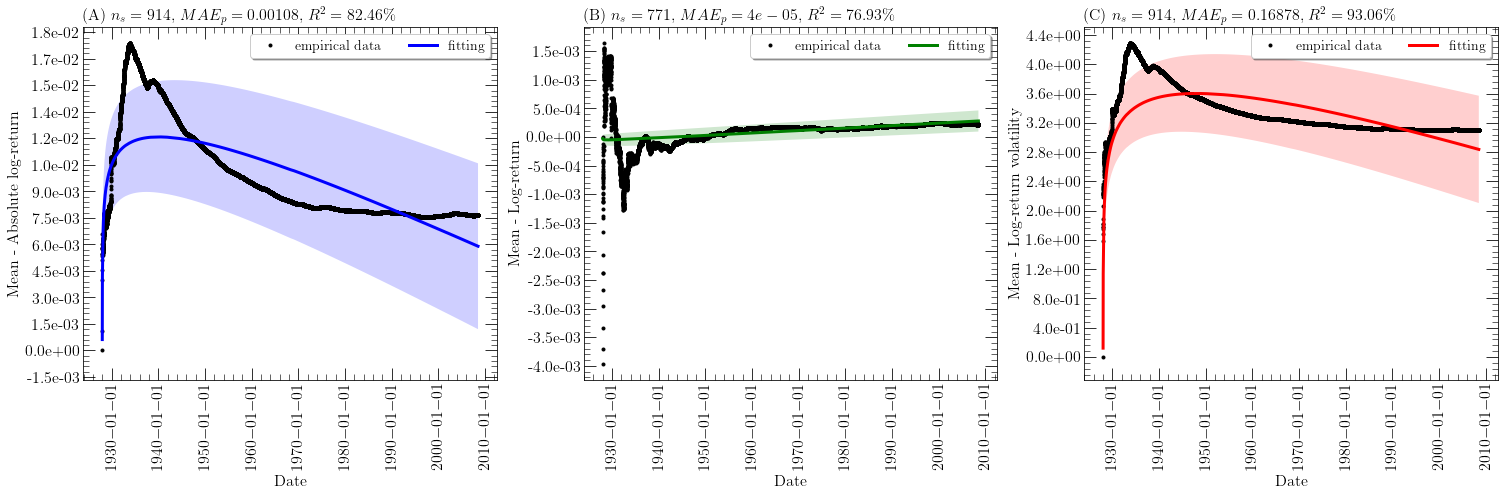

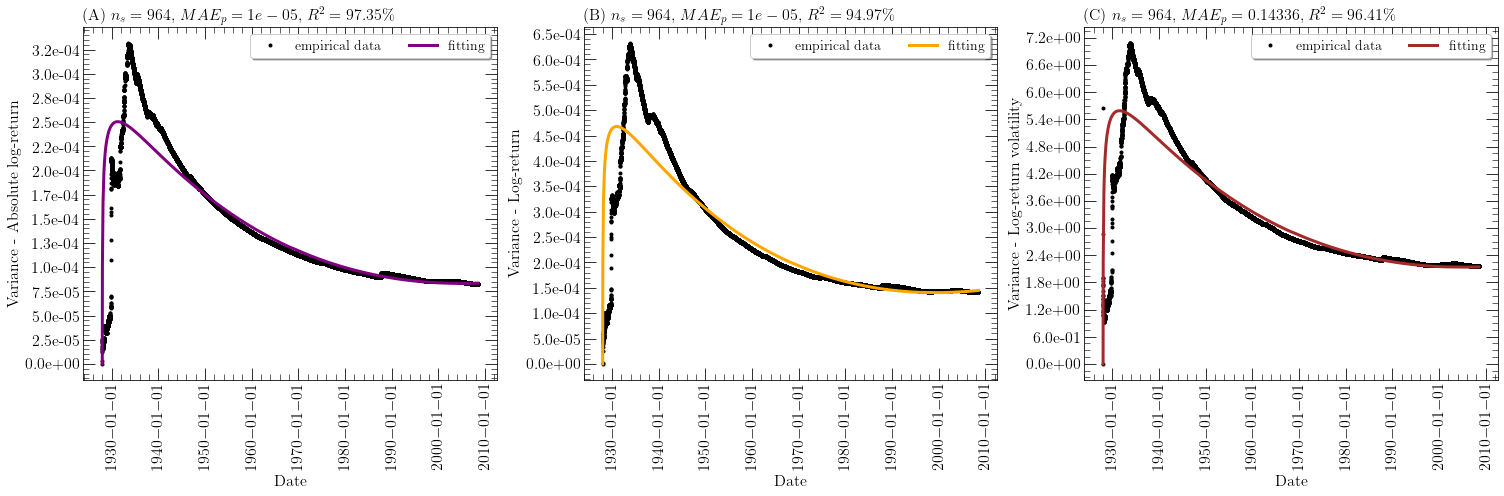

Generated plot for ^DJI and time series absolute log-return
Generated plot for ^DJI and time series log-return
Generated plot for ^DJI and time series log-return volatility


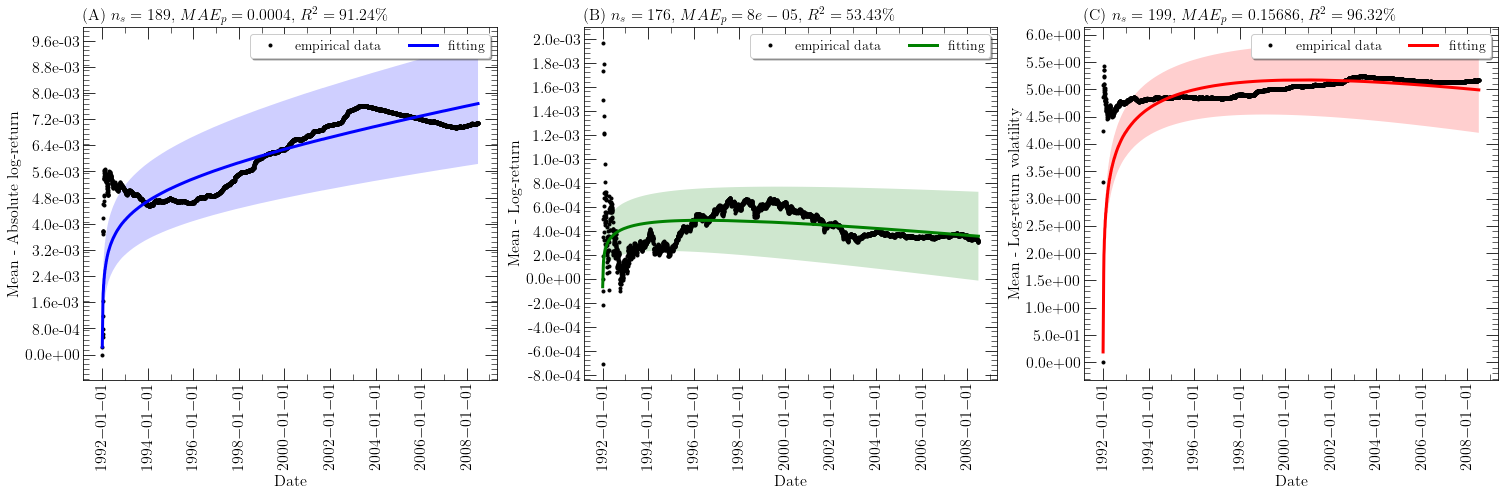

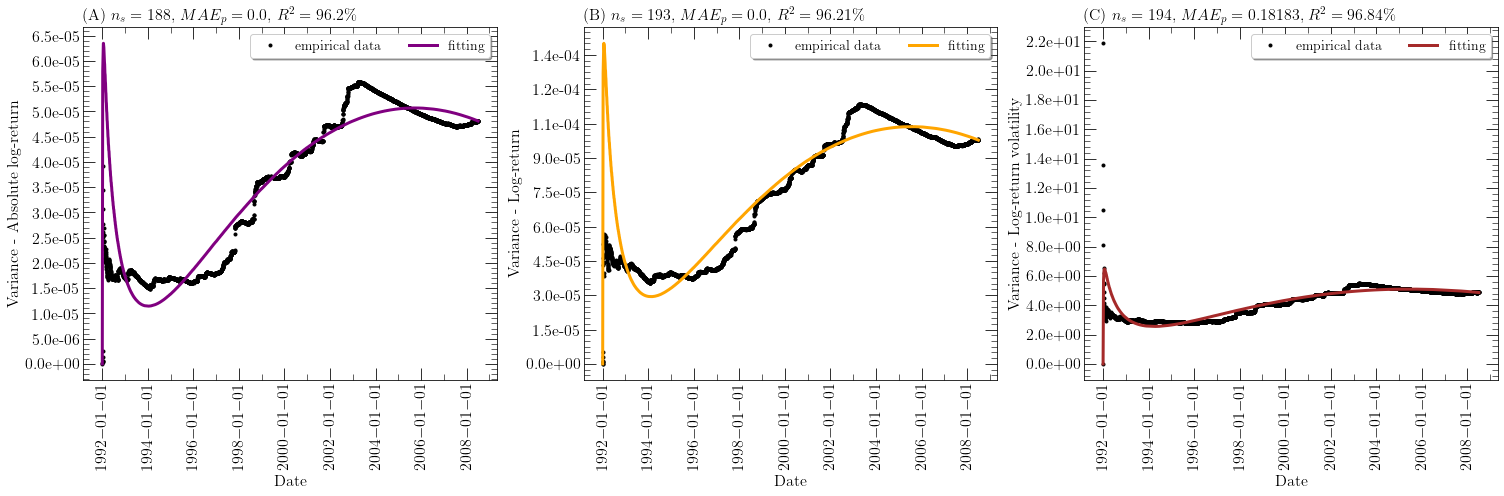

Generated plot for GBPUSD=X and time series absolute log-return
Generated plot for GBPUSD=X and time series log-return
Generated plot for GBPUSD=X and time series log-return volatility


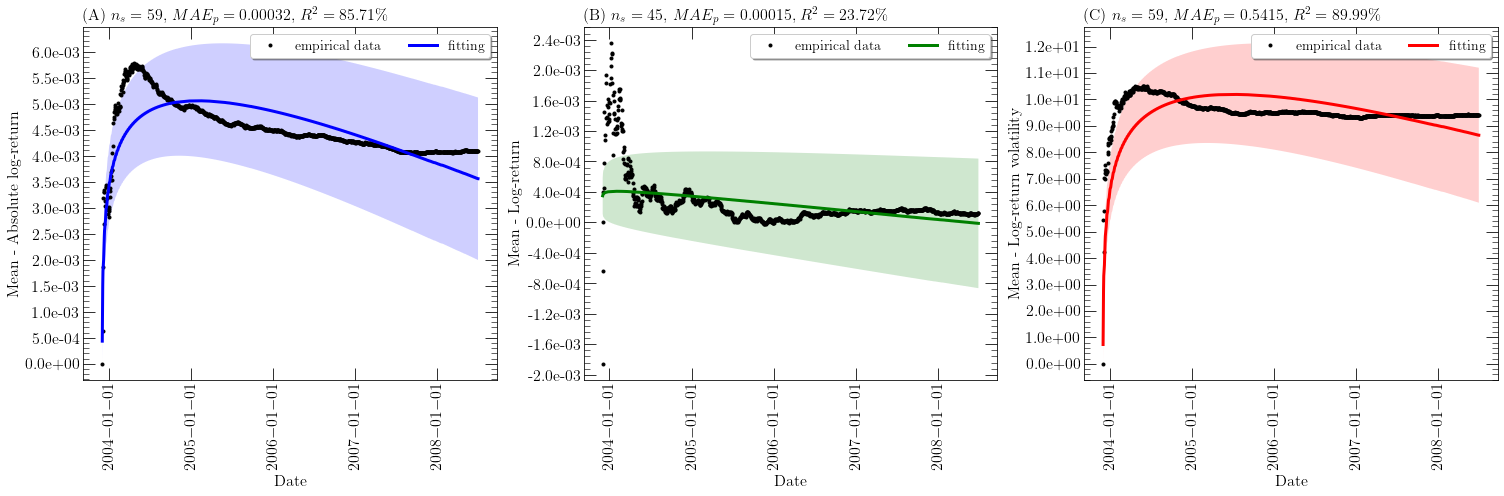

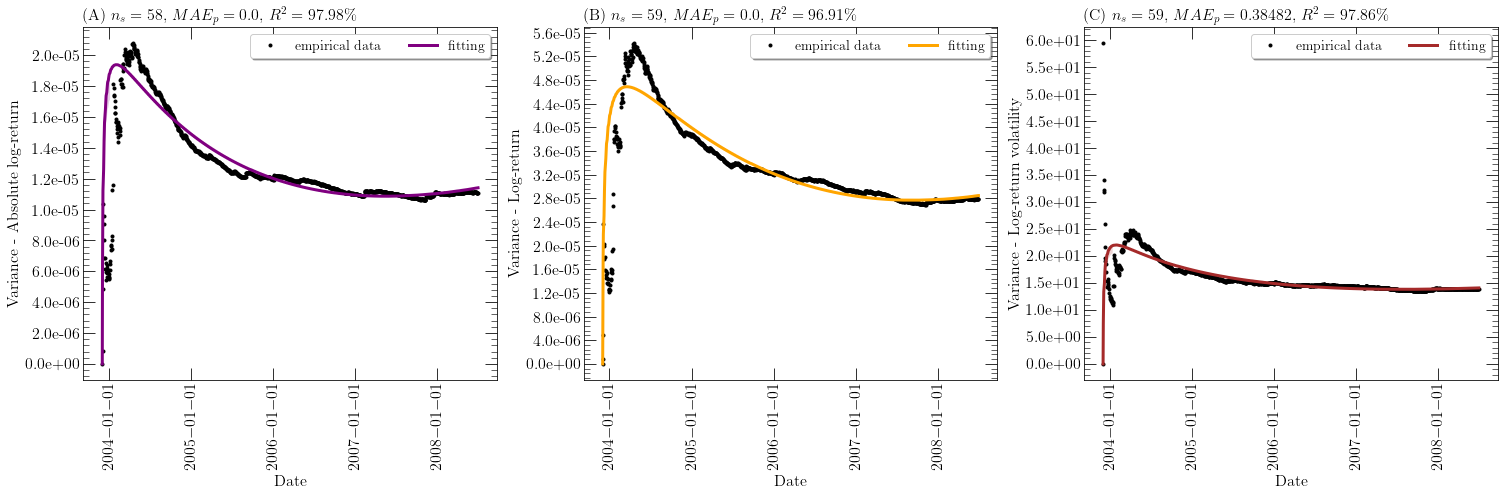

Generated plot for CHFUSD=X and time series absolute log-return
Generated plot for CHFUSD=X and time series log-return
Generated plot for CHFUSD=X and time series log-return volatility


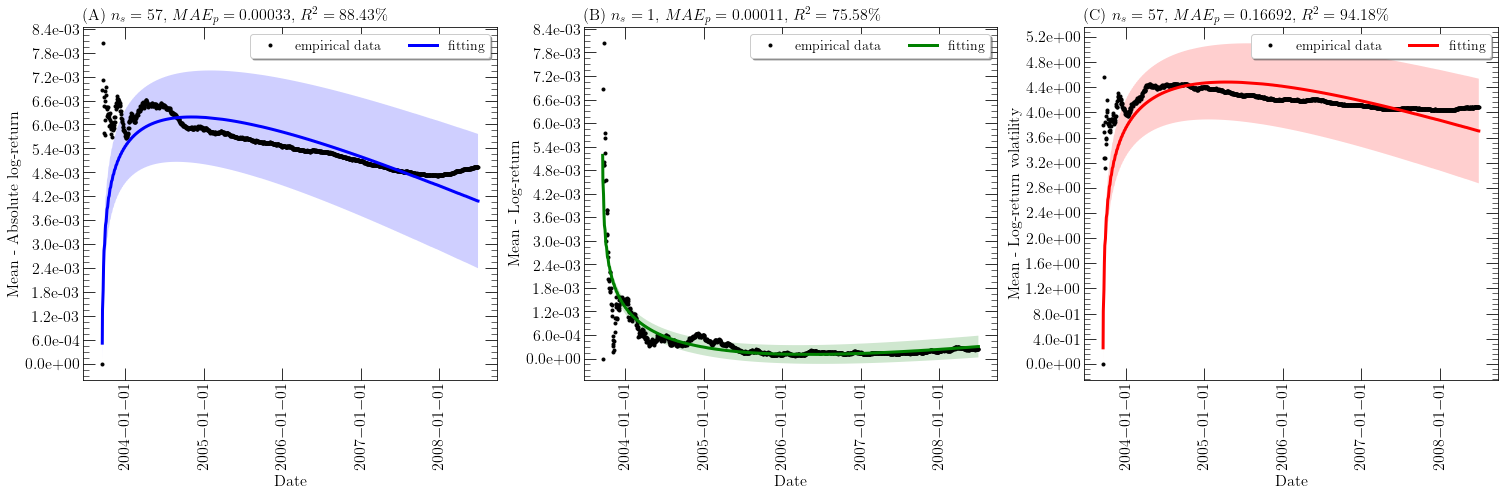

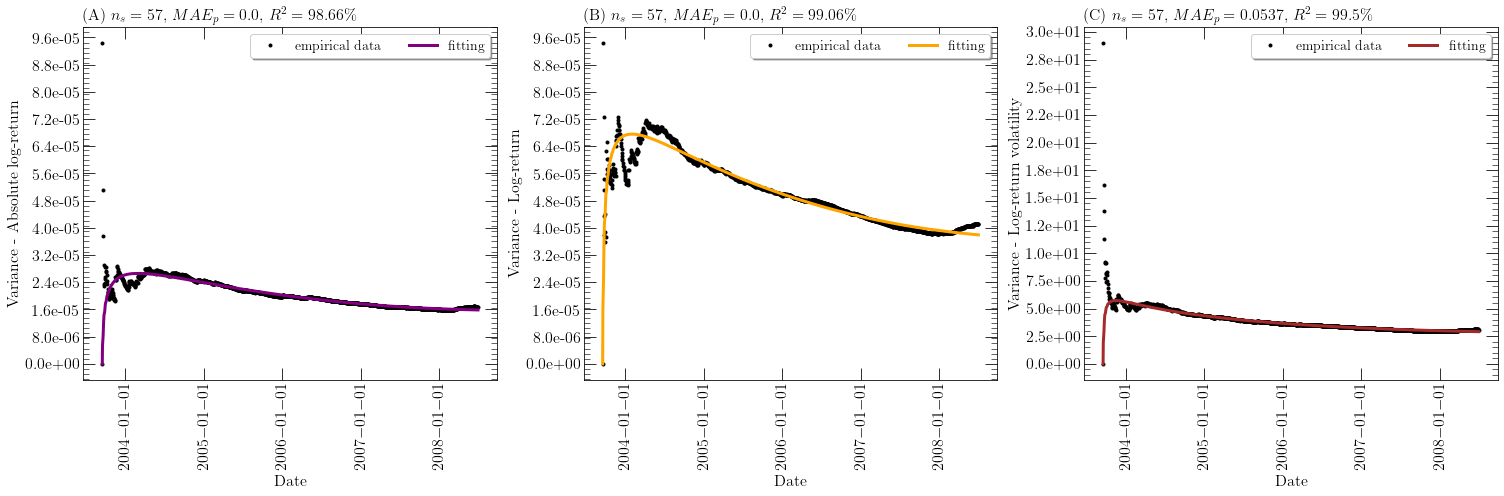

Generated plot for EURUSD=X and time series absolute log-return
Generated plot for EURUSD=X and time series log-return
Generated plot for EURUSD=X and time series log-return volatility


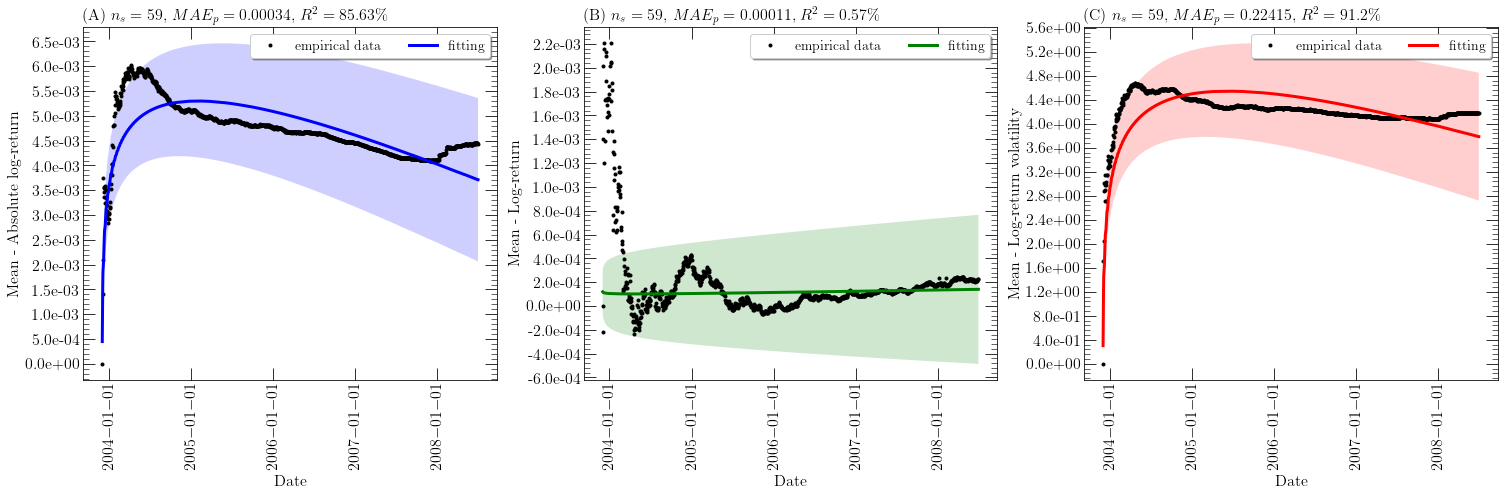

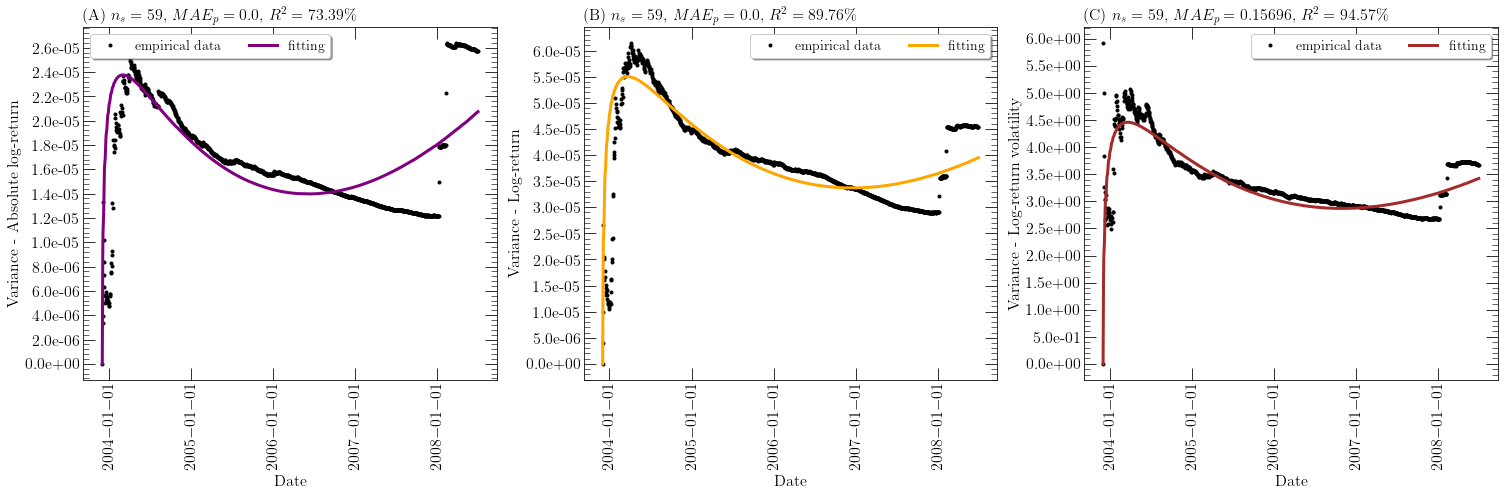

In [12]:
for ticker, ticker_name in list_tickers.items():
    df_graph = plt_ow.plot_optimal_window(
        df_fts = df_derivatives[df_derivatives["date"] <= max_date_1],
        df_optimal = df_optimal_derivatives_1,
        interval = "days",
        symbols = [ticker],
        width = 21,
        height = 7,
        all_data = True,
        markersize = 3,
        fontsize_labels = 16,
        fontsize_legend = 14,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 15,
        n_y_breaks = 15,
        fancy_legend = True,
        dpi = 300,
        save_figures = True,
        output_path = "{}/{}/aesepelt".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = "{}_1".format(re.sub("(\^)|(=X)", "", ticker)),
        input_generation_date = input_generation_date
    )

Generated plot for ^GSPC and time series absolute log-return
Generated plot for ^GSPC and time series log-return
Generated plot for ^GSPC and time series log-return volatility


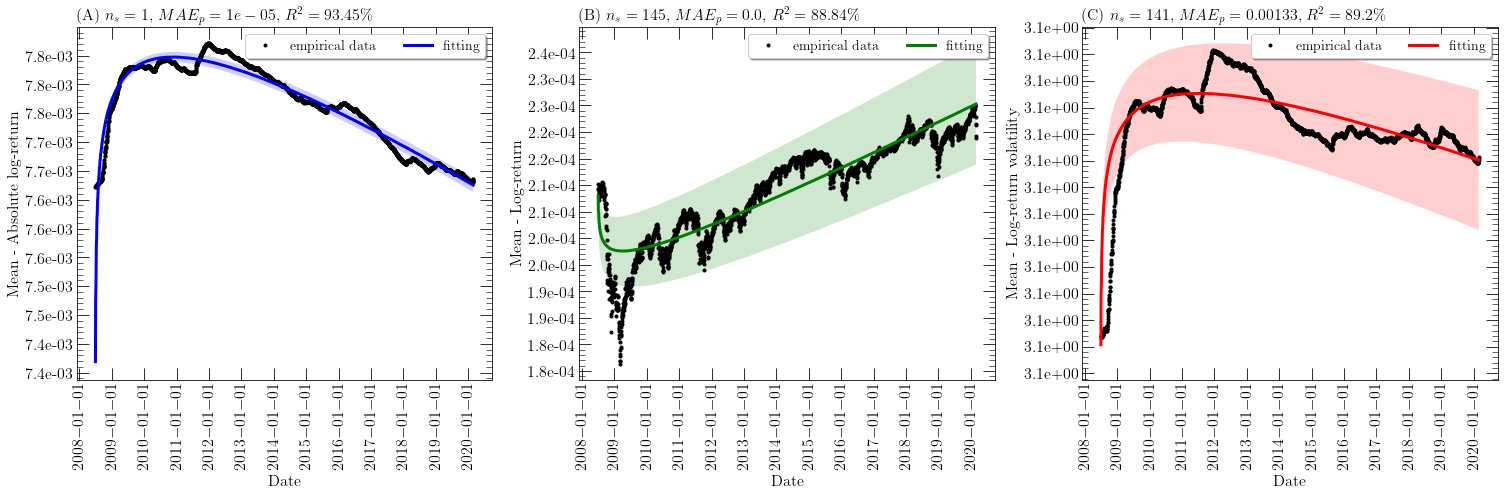

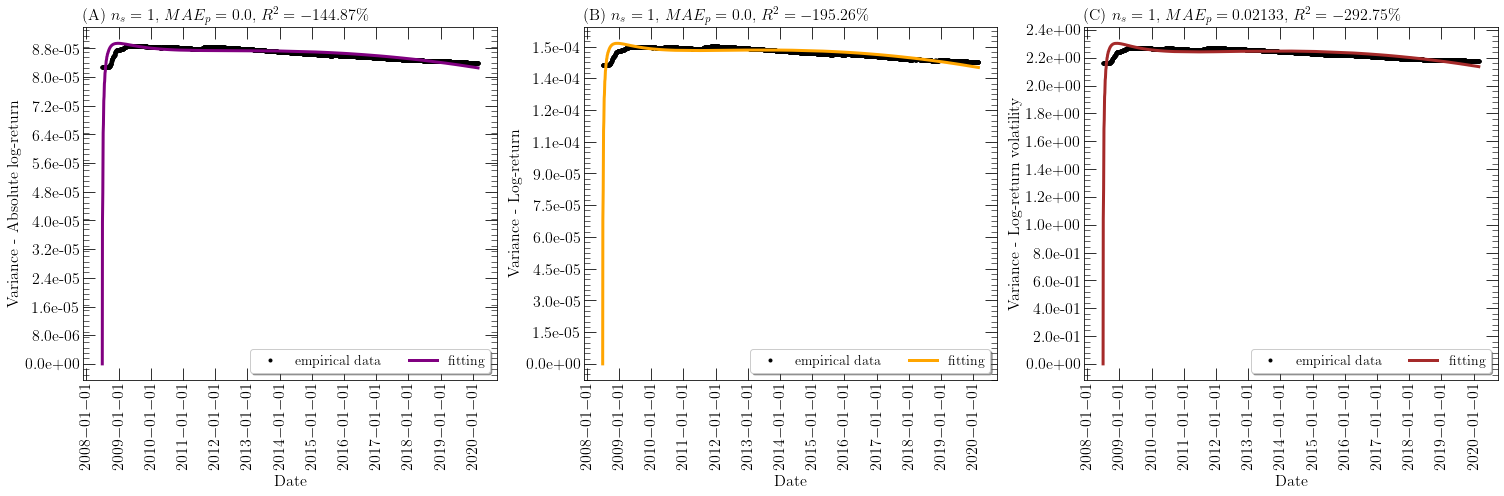

Generated plot for ^DJI and time series absolute log-return
Generated plot for ^DJI and time series log-return
Generated plot for ^DJI and time series log-return volatility


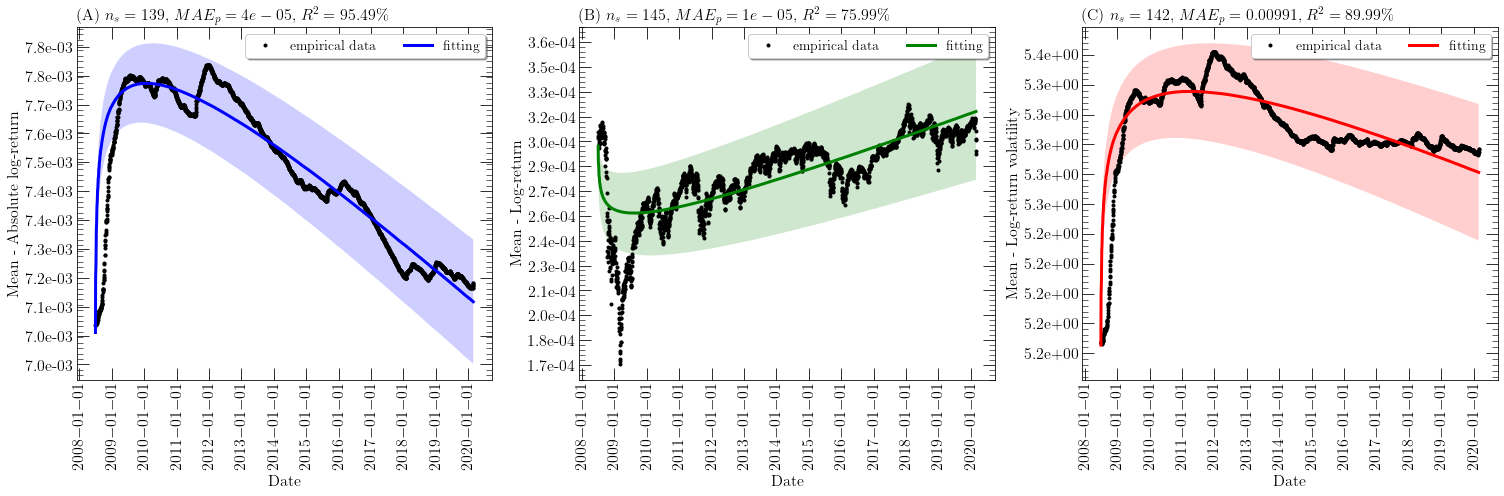

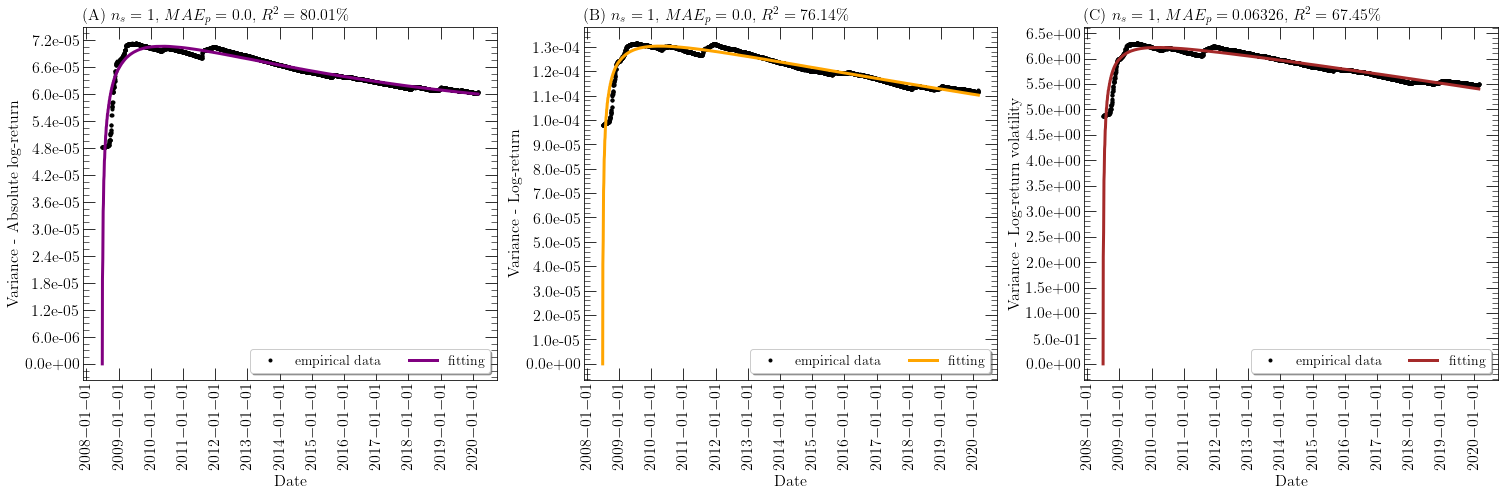

Generated plot for GBPUSD=X and time series absolute log-return
Generated plot for GBPUSD=X and time series log-return
Generated plot for GBPUSD=X and time series log-return volatility


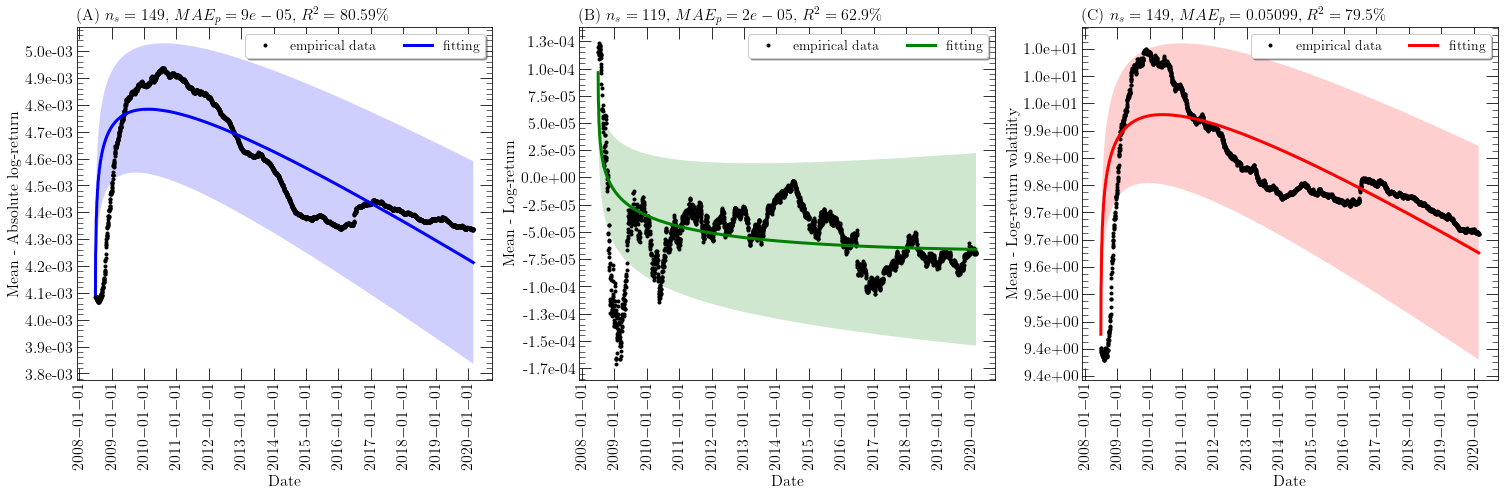

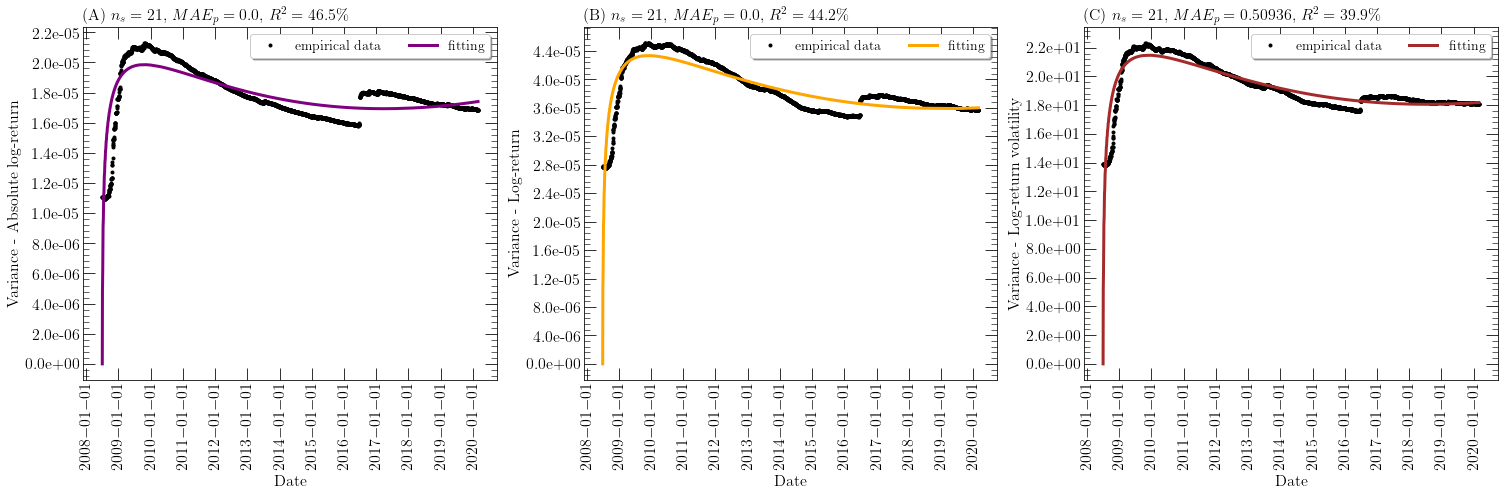

Generated plot for CHFUSD=X and time series absolute log-return
Generated plot for CHFUSD=X and time series log-return
Generated plot for CHFUSD=X and time series log-return volatility


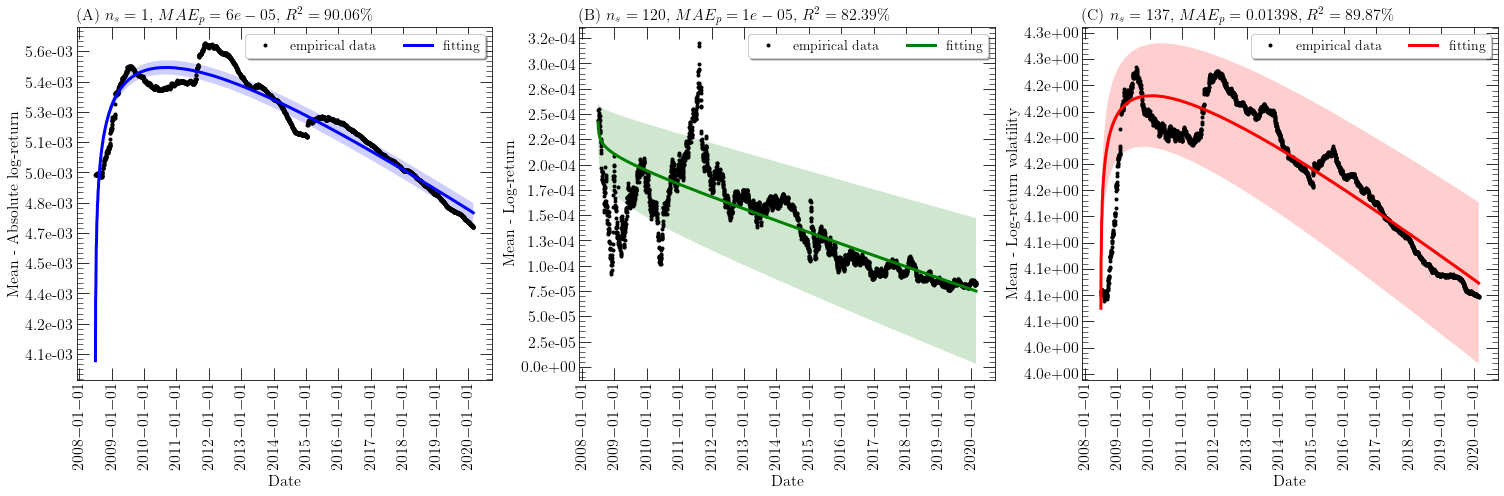

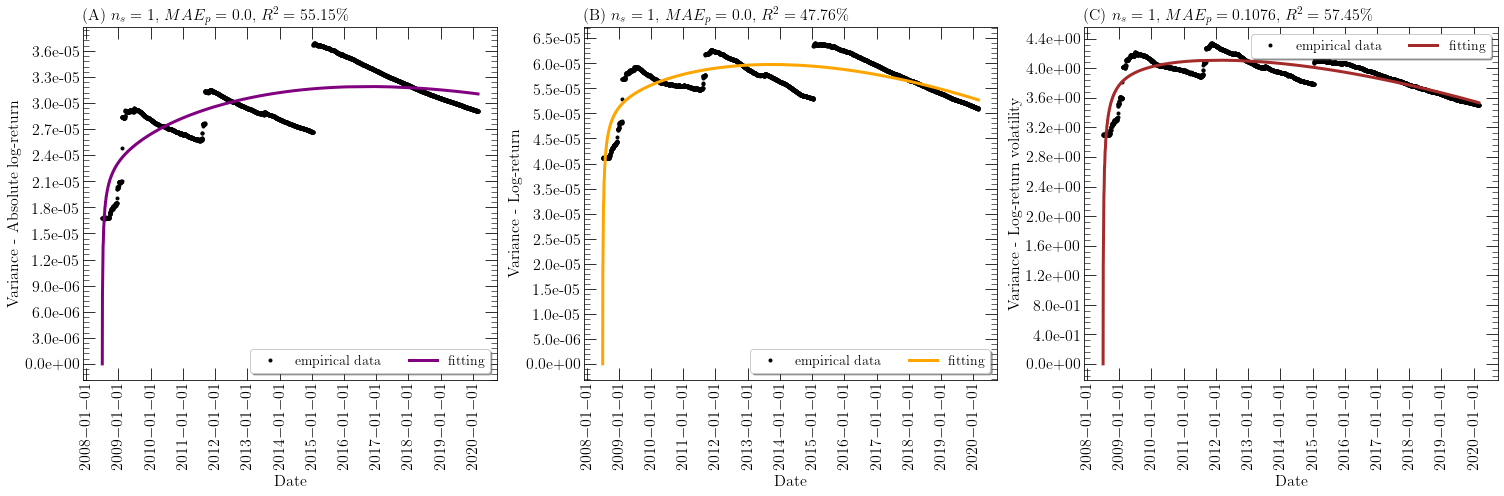

Generated plot for EURUSD=X and time series absolute log-return
Generated plot for EURUSD=X and time series log-return
Generated plot for EURUSD=X and time series log-return volatility


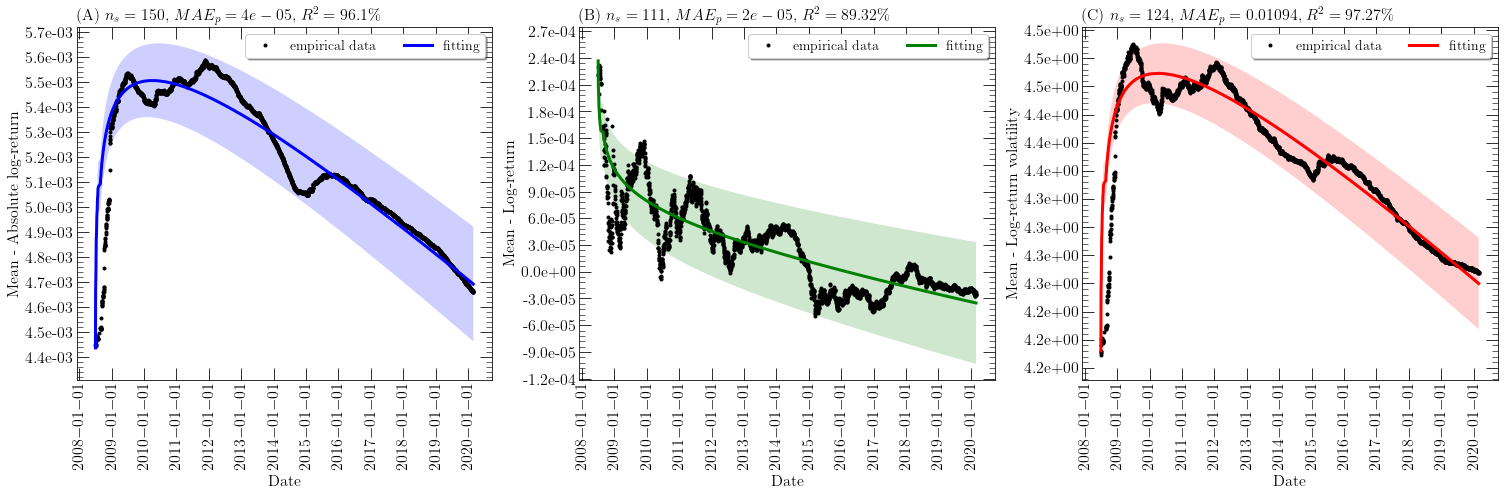

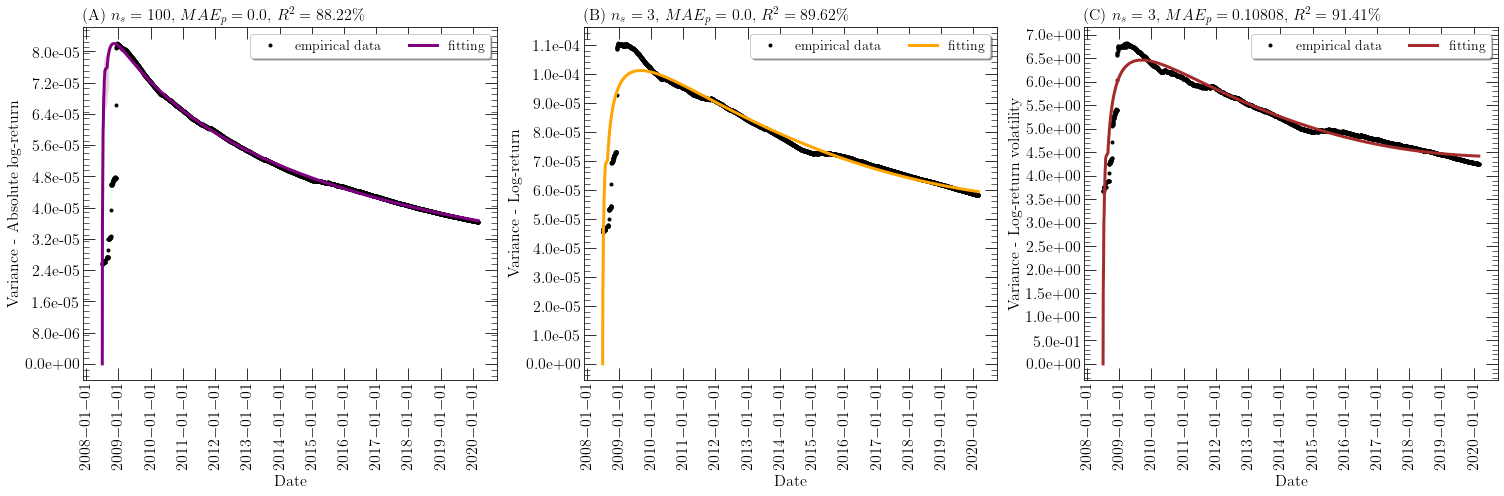

In [13]:
A = df_derivatives[((df_derivatives["date"] >= max_date_1) & (df_derivatives["date"] <= max_date_2))]
A["step"] = A.groupby(["symbol"])["step"].transform(lambda x: x - np.min(x))
for ticker, ticker_name in list_tickers.items():
    df_graph = plt_ow.plot_optimal_window(
        df_fts = A,
        df_optimal = df_optimal_derivatives_2,
        interval = "days",
        symbols = [ticker],
        width = 21,
        height = 7,
        all_data = True,
        markersize = 3,
        fontsize_labels = 16,
        fontsize_legend = 14,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 15,
        n_y_breaks = 15,
        fancy_legend = True,
        dpi = 300,
        save_figures = True,
        output_path = "{}/{}/aesepelt".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = "{}_2".format(re.sub("(\^)|(=X)", "", ticker)),
        input_generation_date = input_generation_date
    )

Generated plot for ^GSPC and time series absolute log-return
Generated plot for ^GSPC and time series log-return
Generated plot for ^GSPC and time series log-return volatility


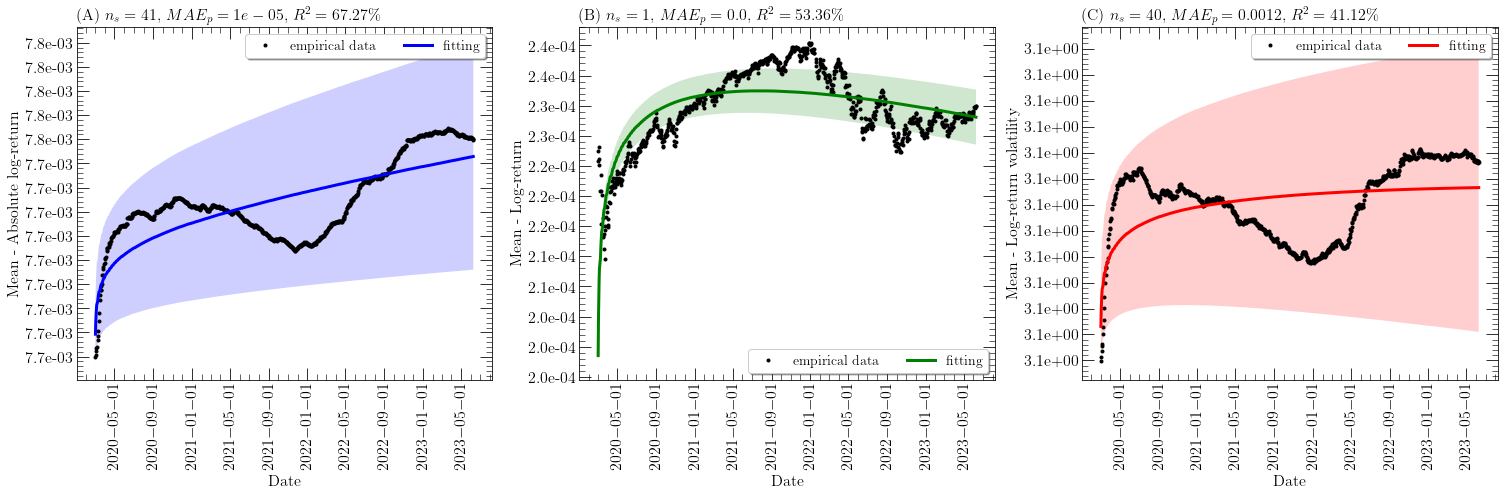

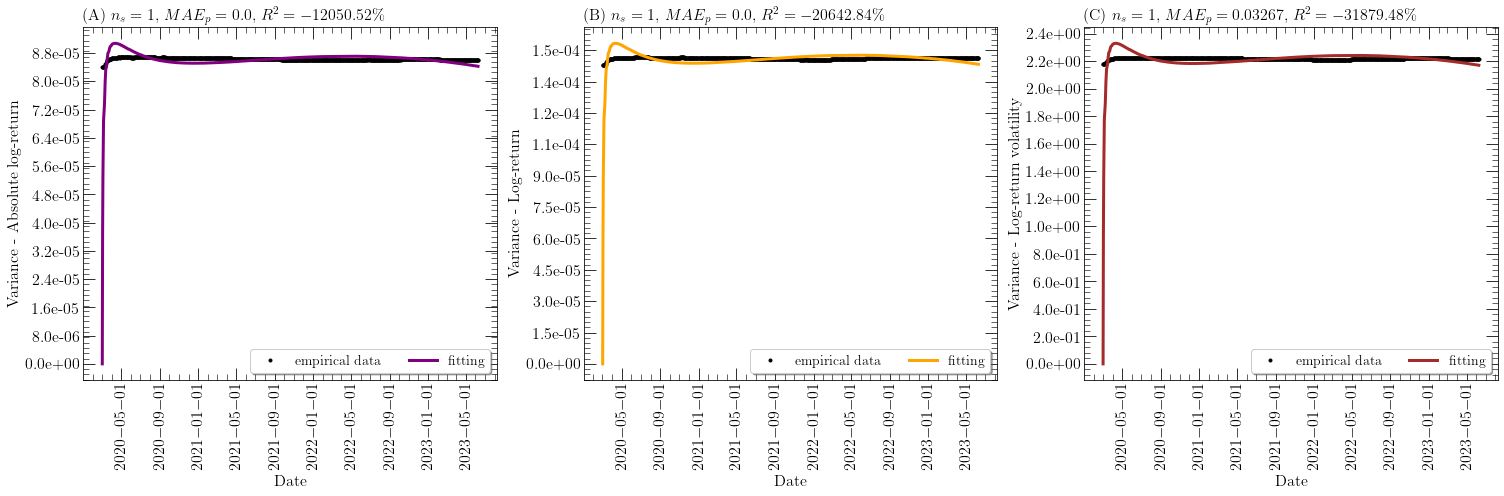

Generated plot for ^DJI and time series absolute log-return
Generated plot for ^DJI and time series log-return
Generated plot for ^DJI and time series log-return volatility


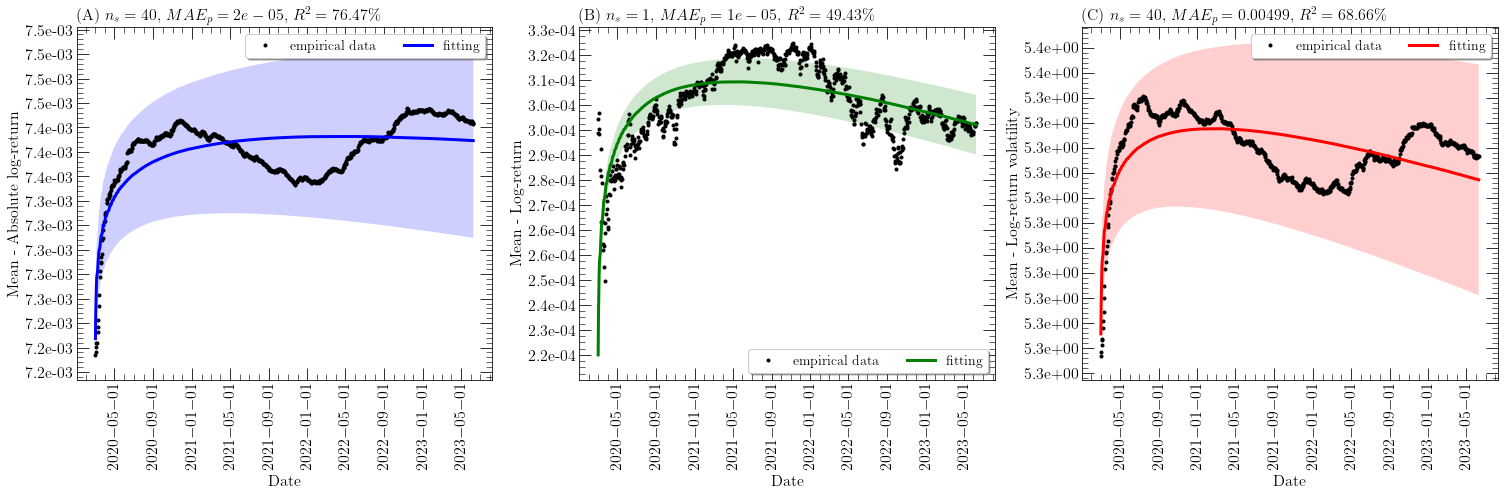

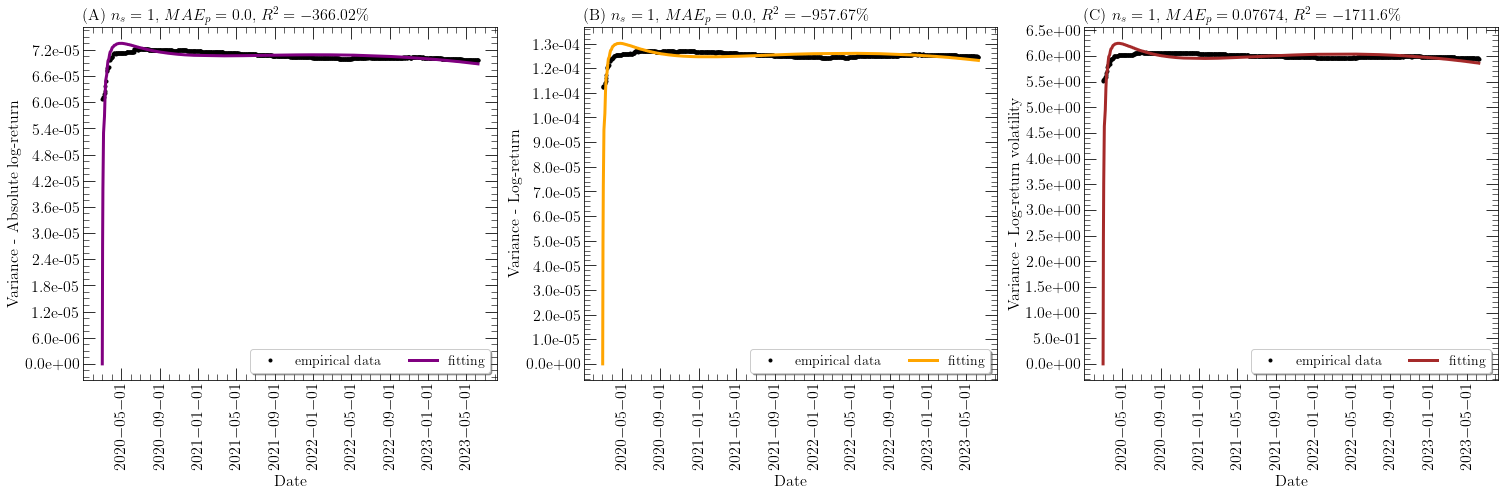

Generated plot for GBPUSD=X and time series absolute log-return
Generated plot for GBPUSD=X and time series log-return
Generated plot for GBPUSD=X and time series log-return volatility


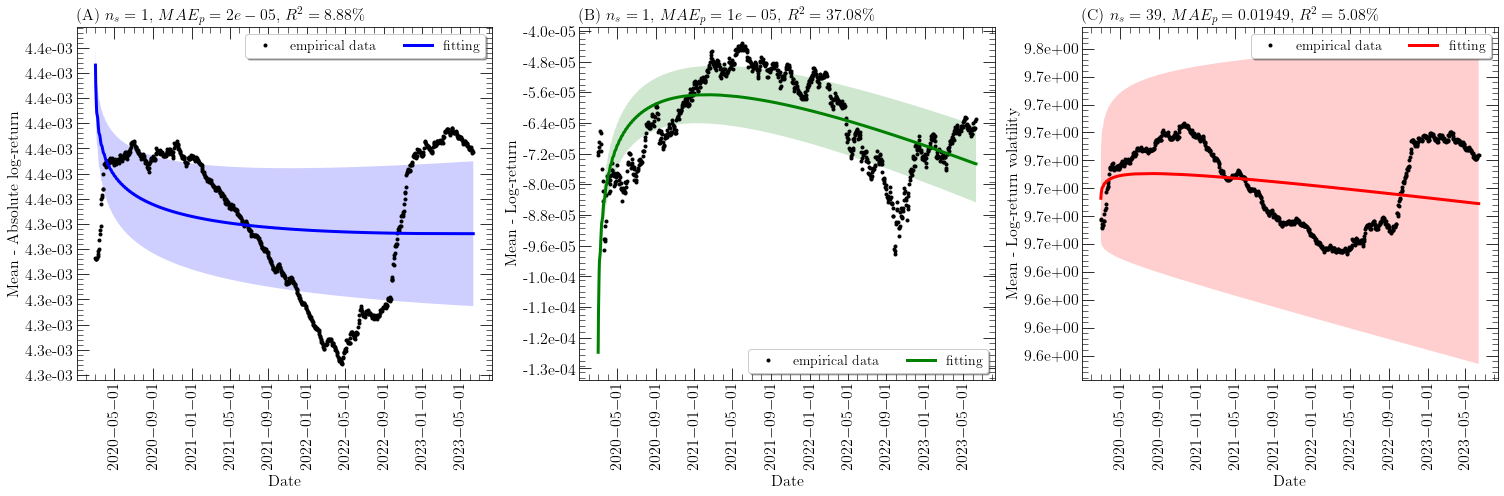

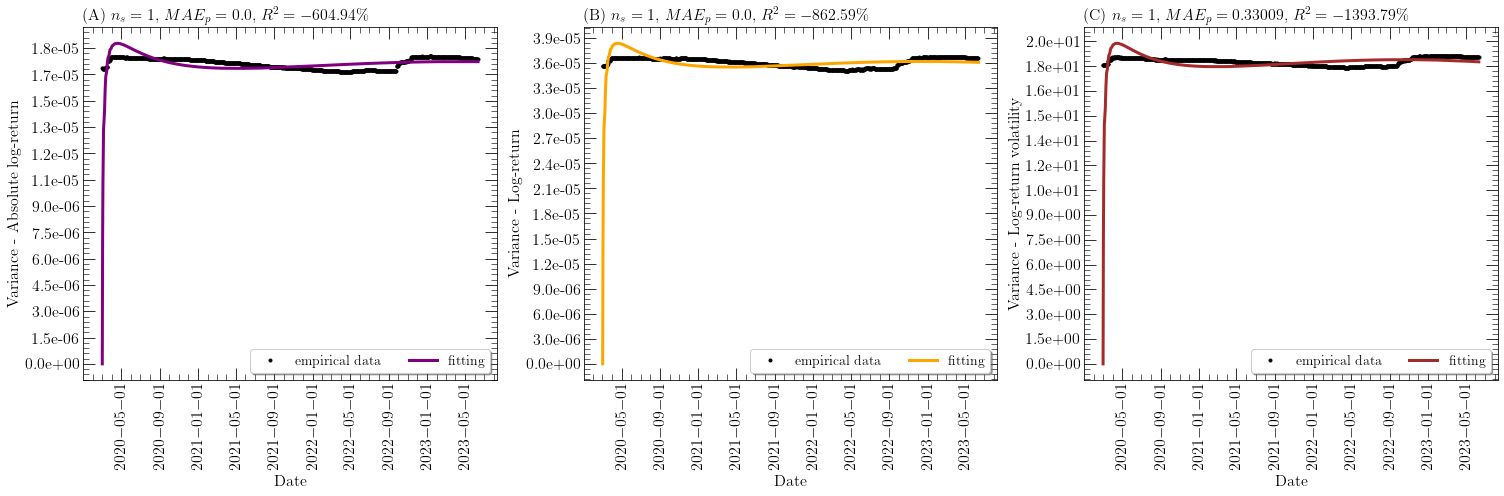

Generated plot for CHFUSD=X and time series absolute log-return
Generated plot for CHFUSD=X and time series log-return
Generated plot for CHFUSD=X and time series log-return volatility


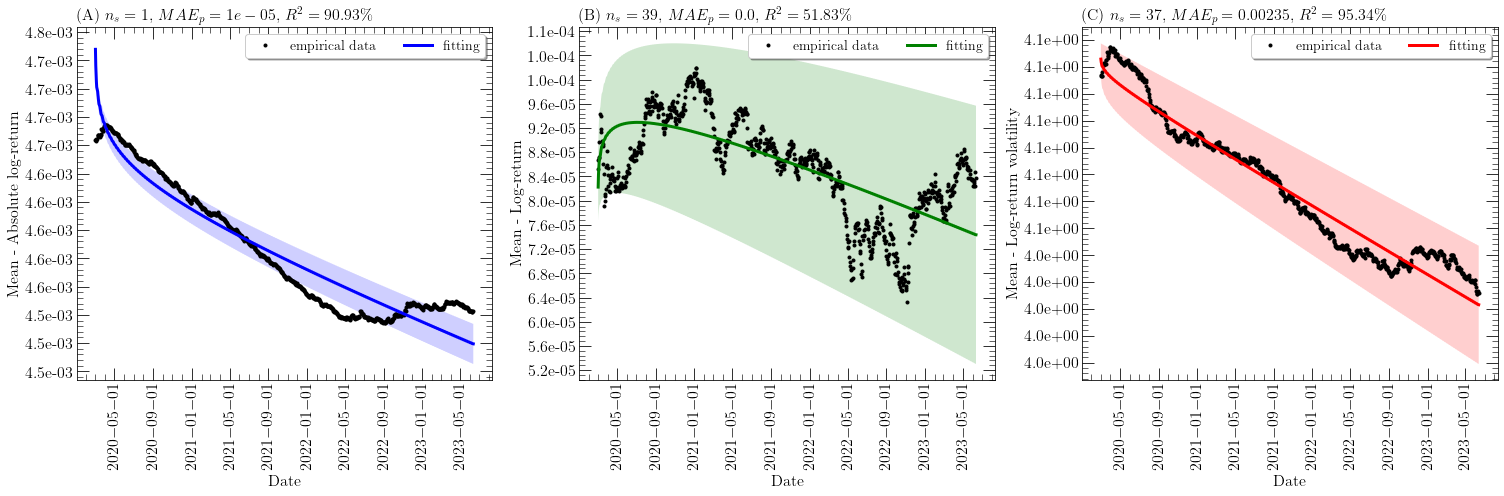

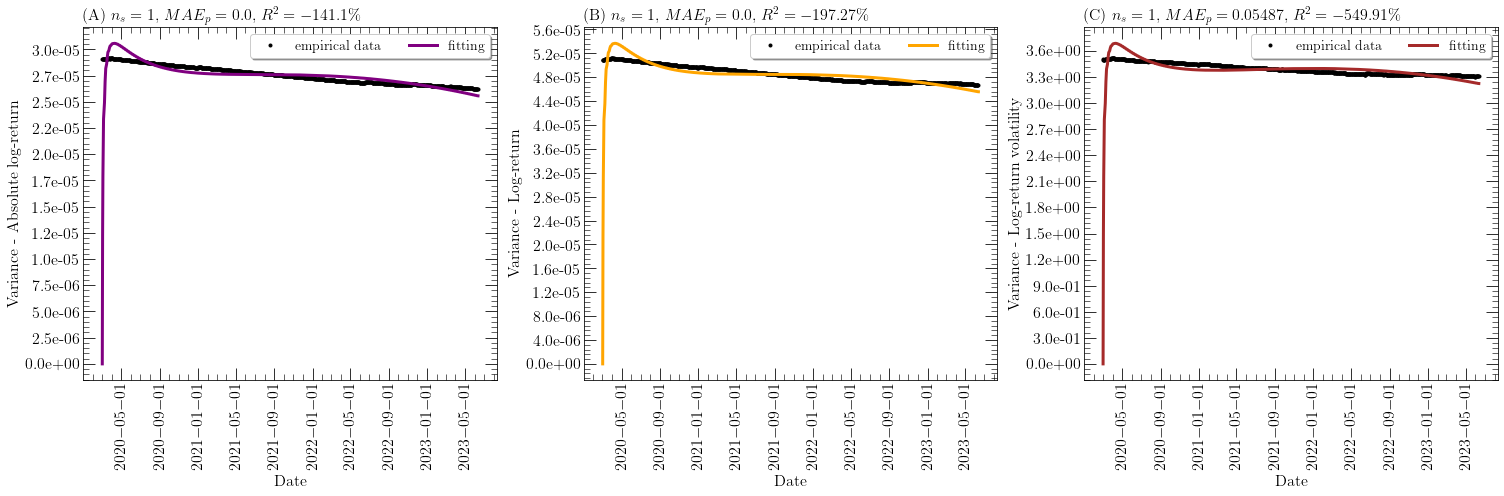

Generated plot for EURUSD=X and time series absolute log-return
Generated plot for EURUSD=X and time series log-return
Generated plot for EURUSD=X and time series log-return volatility


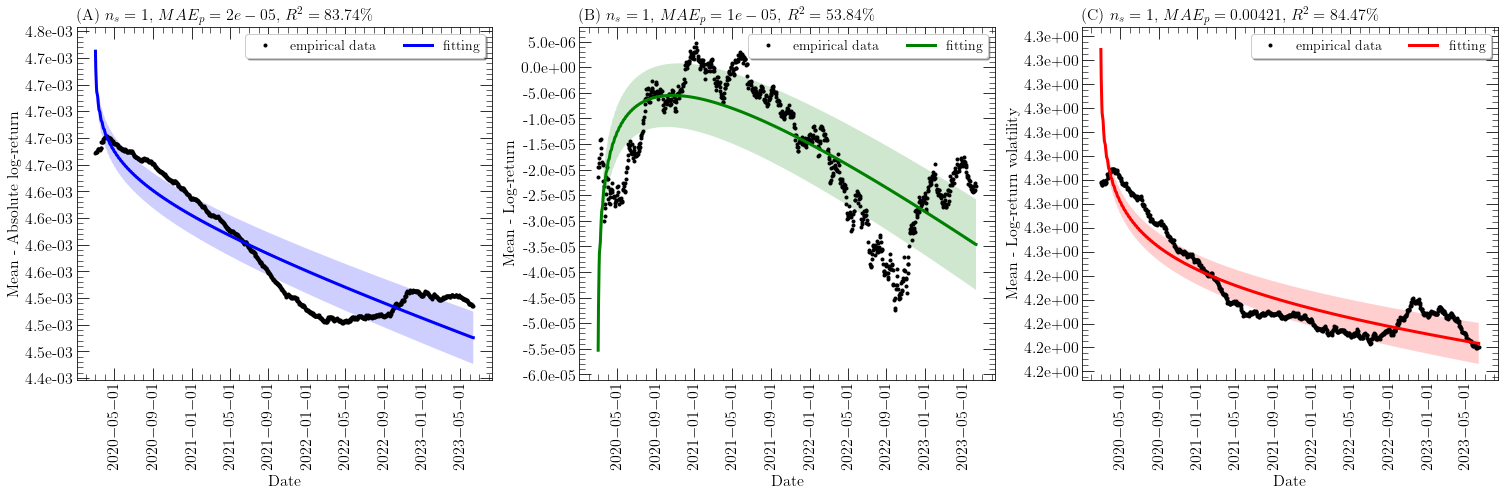

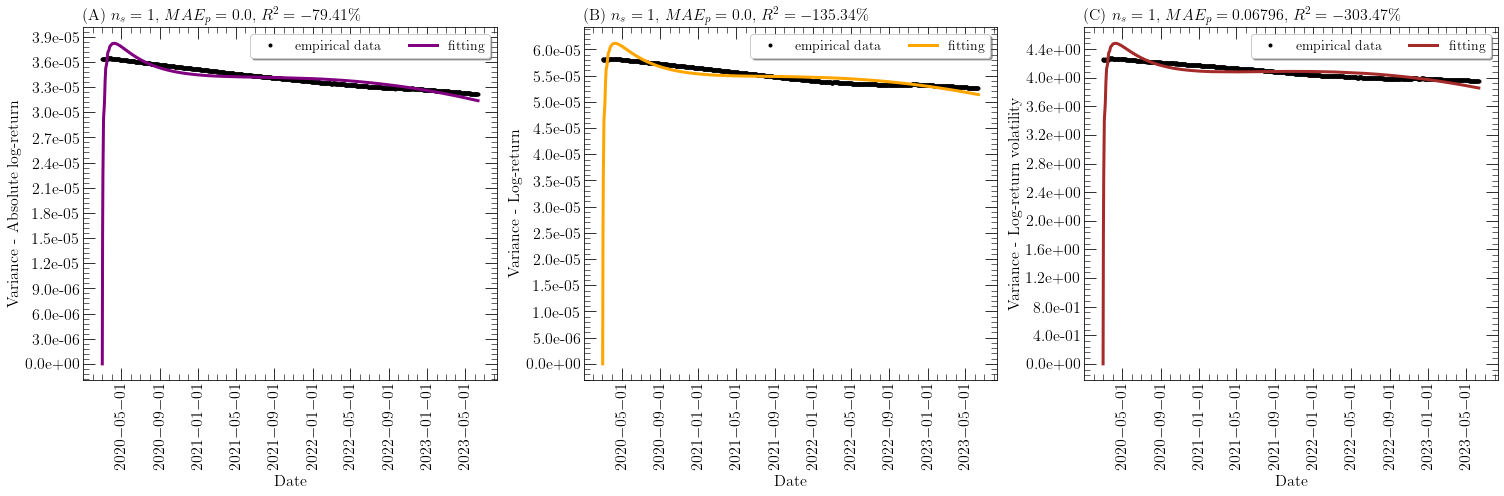

In [14]:
A = df_derivatives[df_derivatives["date"] >= max_date_2]
A["step"] = A.groupby(["symbol"])["step"].transform(lambda x: x - np.min(x))
for ticker, ticker_name in list_tickers.items():
    df_graph = plt_ow.plot_optimal_window(
        df_fts = A,
        df_optimal = df_optimal_derivatives_3,
        interval = "days",
        symbols = [ticker],
        width = 21,
        height = 7,
        all_data = True,
        markersize = 3,
        fontsize_labels = 16,
        fontsize_legend = 14,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 15,
        n_y_breaks = 15,
        fancy_legend = True,
        dpi = 300,
        save_figures = True,
        output_path = "{}/{}/aesepelt".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = "{}_3".format(re.sub("(\^)|(=X)", "", ticker)),
        input_generation_date = input_generation_date
    )

In [15]:
#plt_ow.resume_optimal_window(
#    df_optimal = df_optimal_derivatives_1,
#    symbols_order = list_tickers,
#    precision = 3,
#    output_path = "{}/{}/aesepelt".format(output_path, re.sub("-", "", input_generation_date)),
#    input_generation_date = input_generation_date
#)[0]

## Temporal fluctuation scaling behavior

In [12]:
df_derivatives_tfs_parametelist_tickers etfs.estimate_tfs_parameters(
    df_fts = df_derivatives,
    minimal_steps = 30,
    p_norm = 1,
    log_path = log_path,
    log_filename = "log_aesepelt_derivative_tfs_optimal_window_0_{}".format(re.sub("-", "", input_generation_date)),
    verbose = 1,
    tqdm_bar = True
)
df_derivatives_tfs_parameters_0

100%|█████████████████| 72677/72677 [24:07<00:00, 50.20it/s]


symbol  max_step            time_series  p_norm  coefficient_tfs  \
0       ^GSPC        30             log-return       1              NaN   
1       ^GSPC        30    absolute log-return       1     2.850014e-04   
2       ^GSPC        30  log-return volatility       1     1.491310e+00   
3       ^GSPC        31             log-return       1              NaN   
4       ^GSPC        31    absolute log-return       1     2.908425e-04   
...       ...       ...                    ...     ...              ...   
218026  COP=X      5025    absolute log-return       1     6.489867e+01   
218027  COP=X      5025  log-return volatility       1     4.531624e+07   
218028  COP=X      5026             log-return       1              NaN   
218029  COP=X      5026    absolute log-return       1     6.487677e+01   
218030  COP=X      5026  log-return volatility       1     4.502074e+07   

        error_coefficient_tfs  exponent_tfs  error_exponent_tfs  \
0                         inf           NaN                 inf   
1                3.319845e-04  5.380912e-01            0.225715   
2                1.990278e-01  1.073282e-08            0.143353   
3                         inf           NaN                 inf   
4                3.355639e-04  5.424642e-01            0.223513   
...                       ...           ...                 ...   
218026           2.240412e+00  1.846031e+00            0.009705   
218027           7.722786e+07  7.804693e+00            0.534892   
218028                    inf           NaN                 inf   
218029           2.239120e+00  1.845930e+00            0.009703   
218030           7.666506e+07  7.802576e+00            0.534741   

        average_error_tfs  rsquared_tfs  
0                     NaN           NaN  
1                0.000002      0.580146  
2                0.434781      0.091552  
3                     NaN           NaN  
4                0.000002      0.578598  
...                   ...           ...  
218026           0.006067      0.975800  
218027           0.000741      0.075162  
218028                NaN           NaN  
218029           0.006067      0.975799  
218030           0.000741      0.075140  

[218031 rows x 10 columns]

Generated plot for ^GSPC and time series absolute log-return
Generated plot for ^GSPC and time series log-return volatility


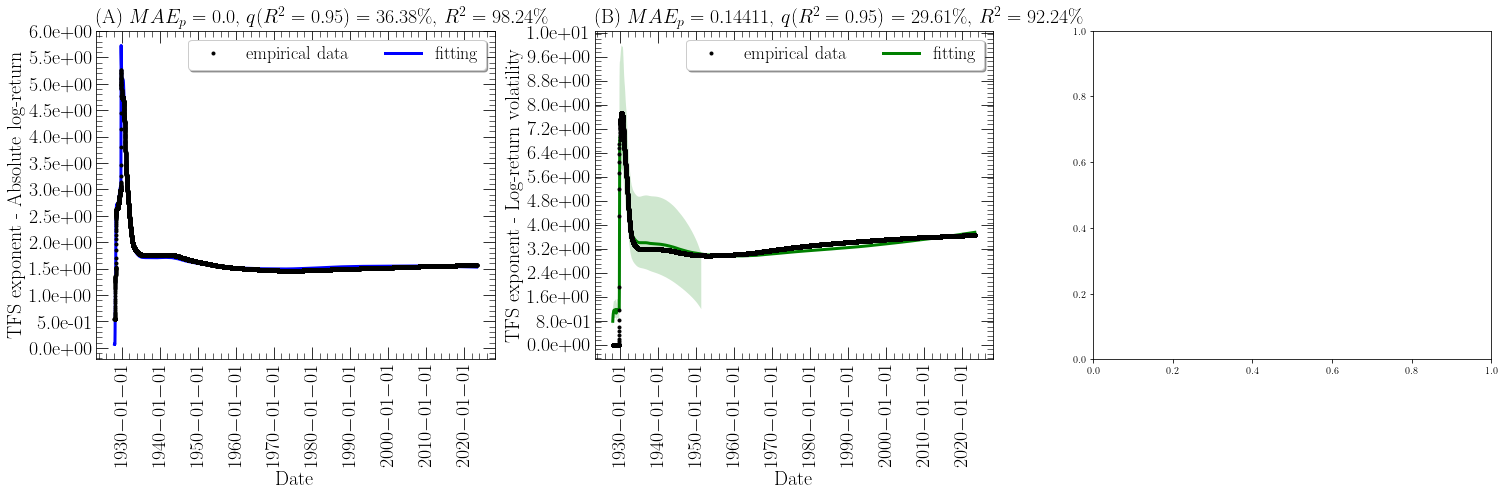

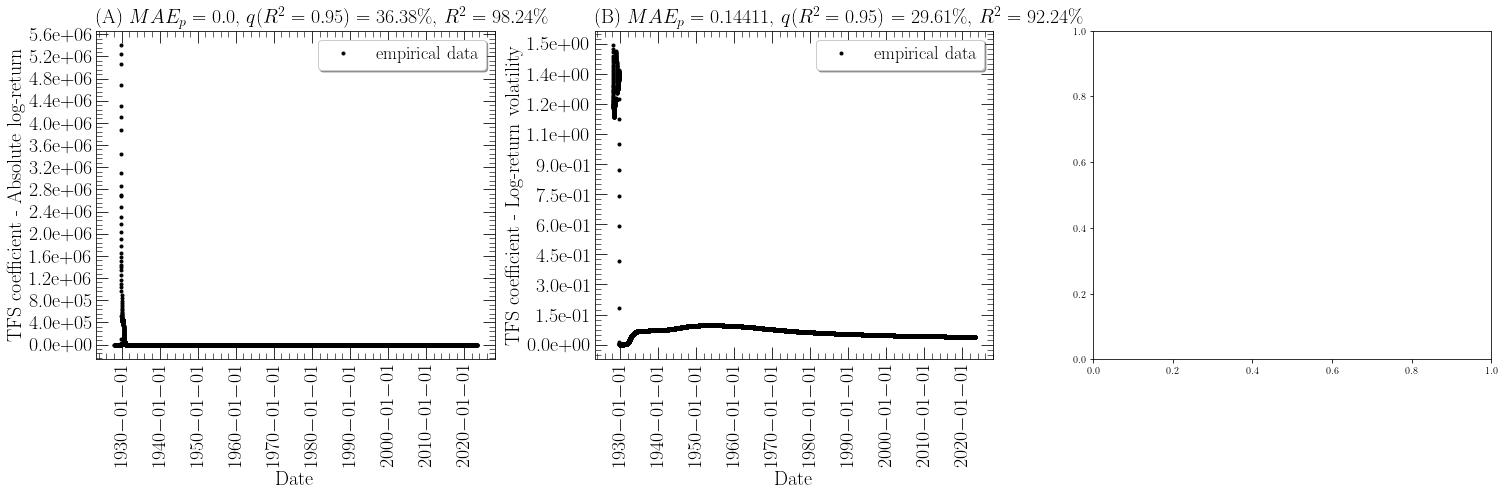

Generated plot for ^DJI and time series absolute log-return
Generated plot for ^DJI and time series log-return volatility


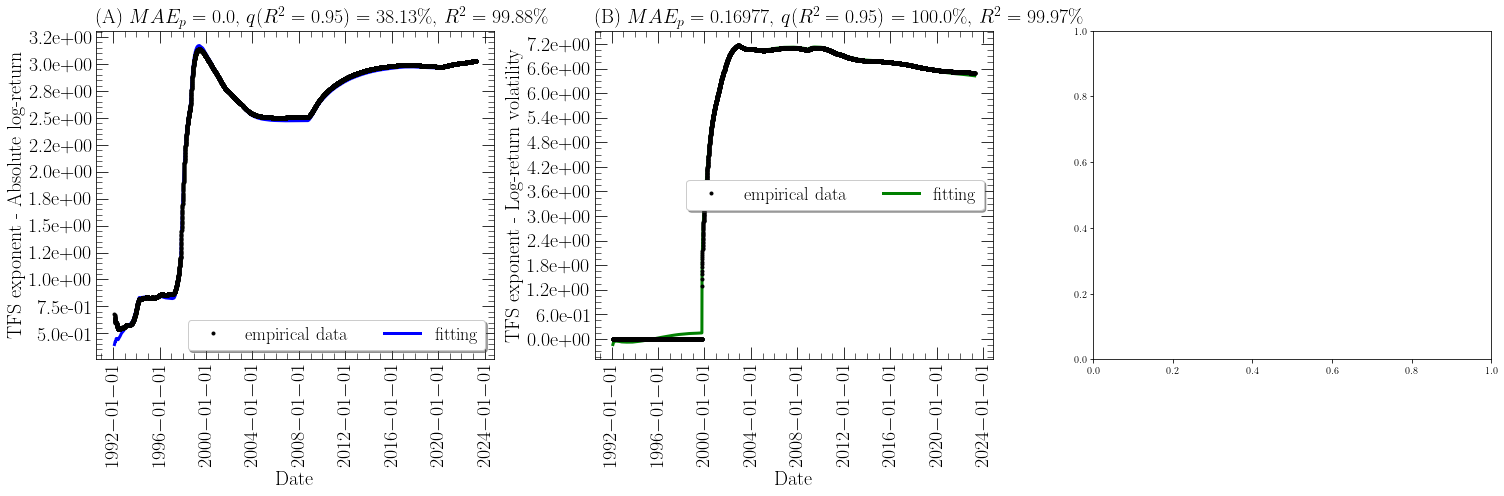

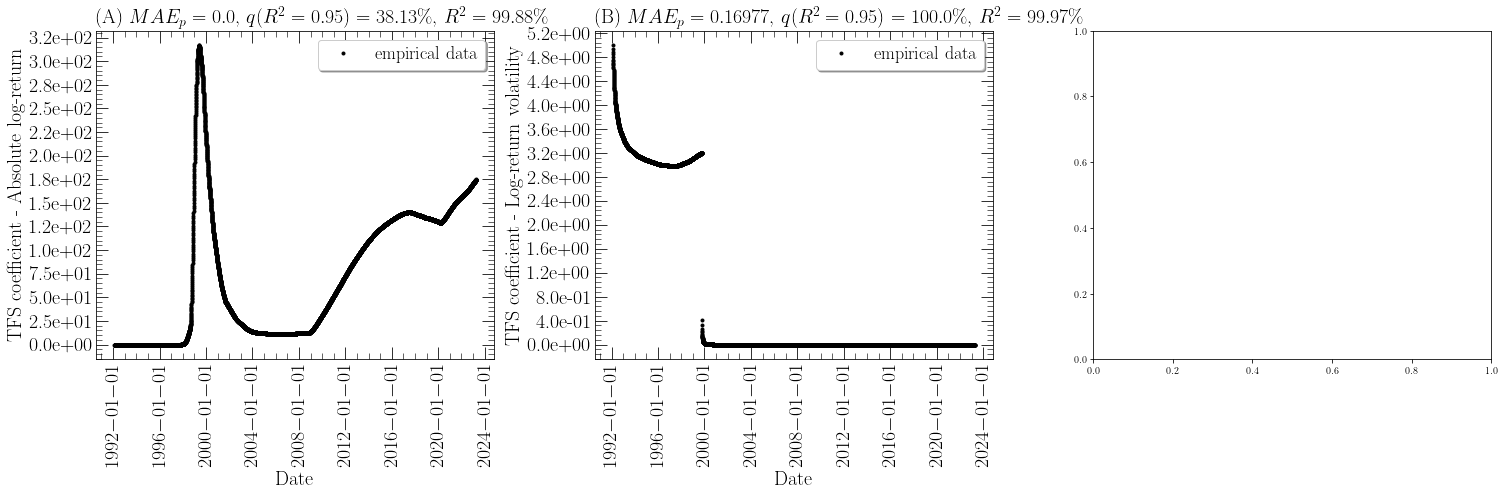

Generated plot for ^N225 and time series absolute log-return
Generated plot for ^N225 and time series log-return volatility


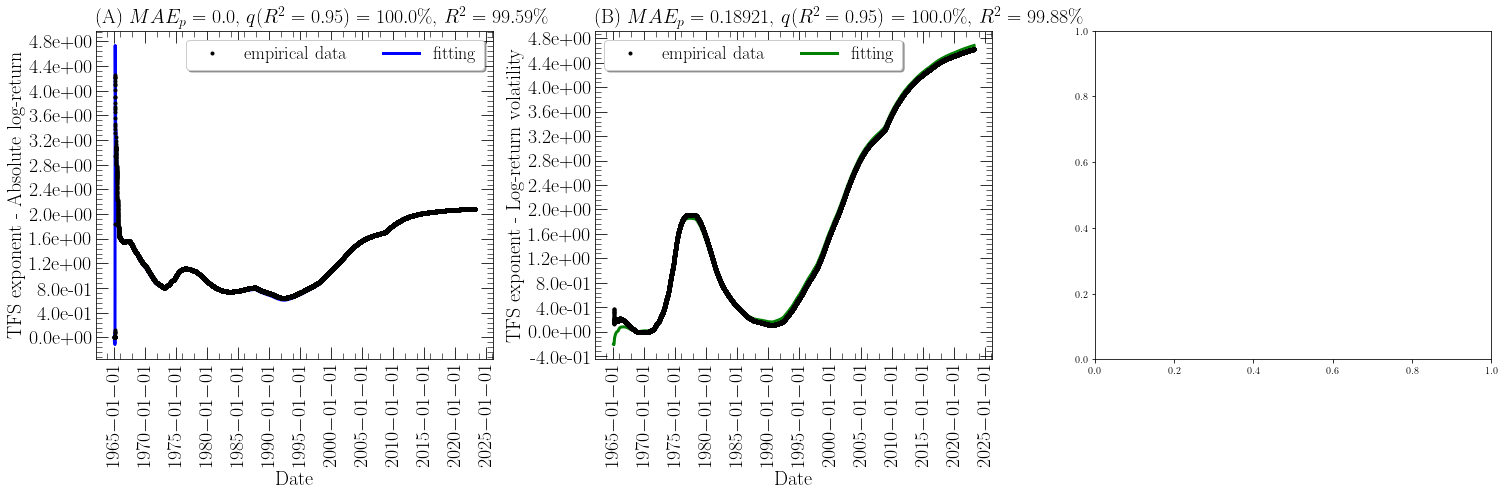

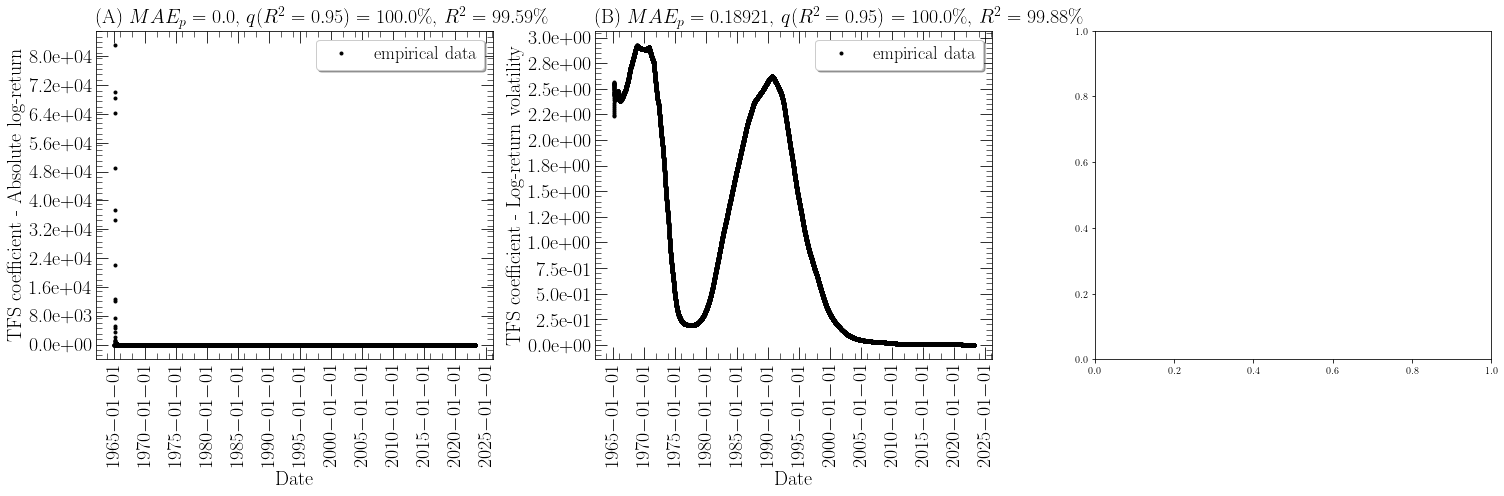

Generated plot for ^BVSP and time series absolute log-return
Generated plot for ^BVSP and time series log-return volatility


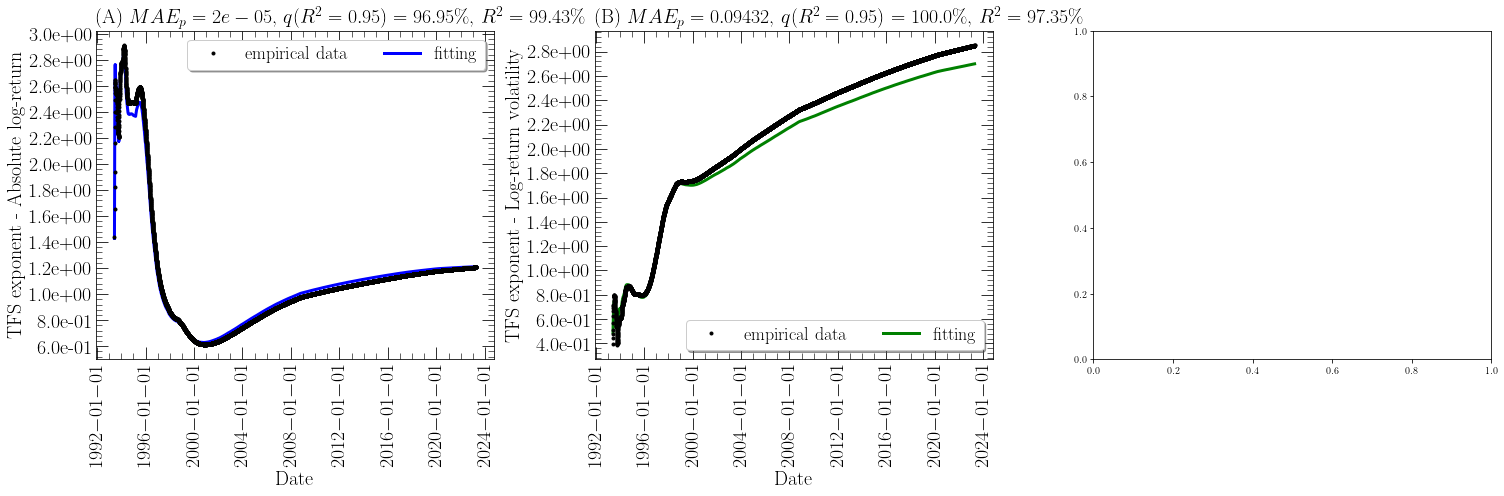

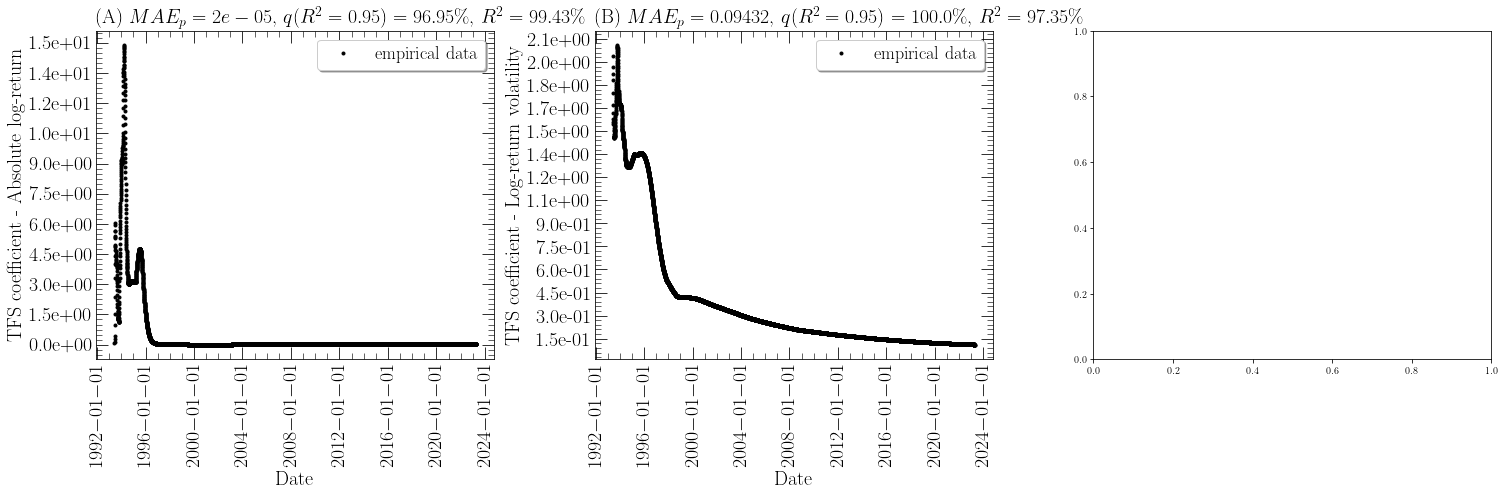

Generated plot for GBPUSD=X and time series absolute log-return
Generated plot for GBPUSD=X and time series log-return volatility


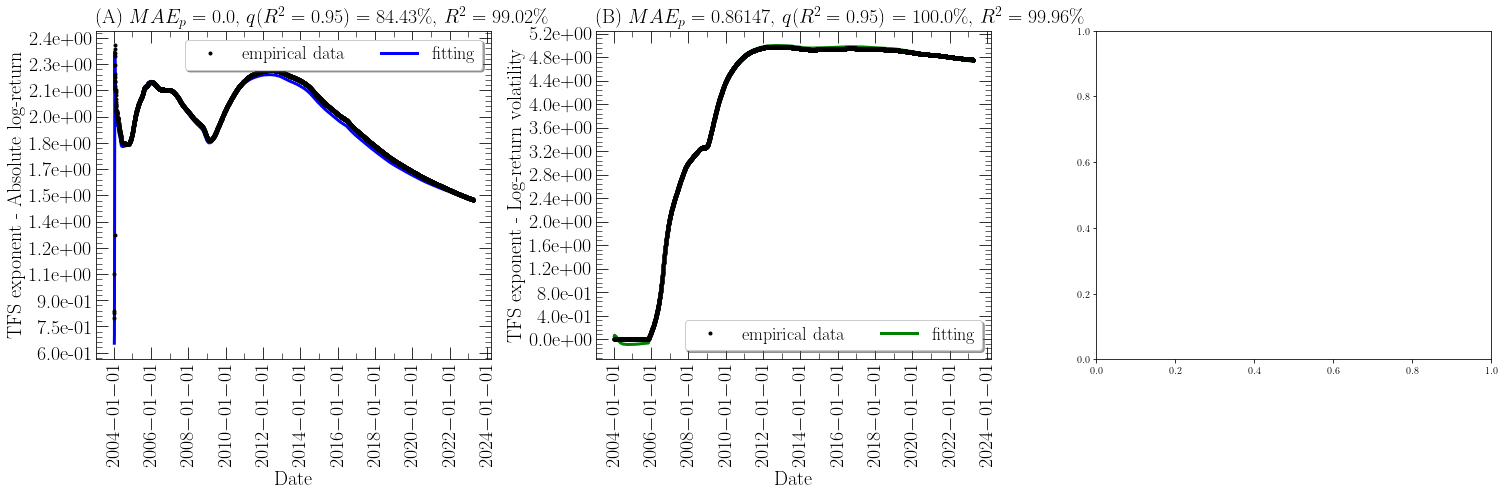

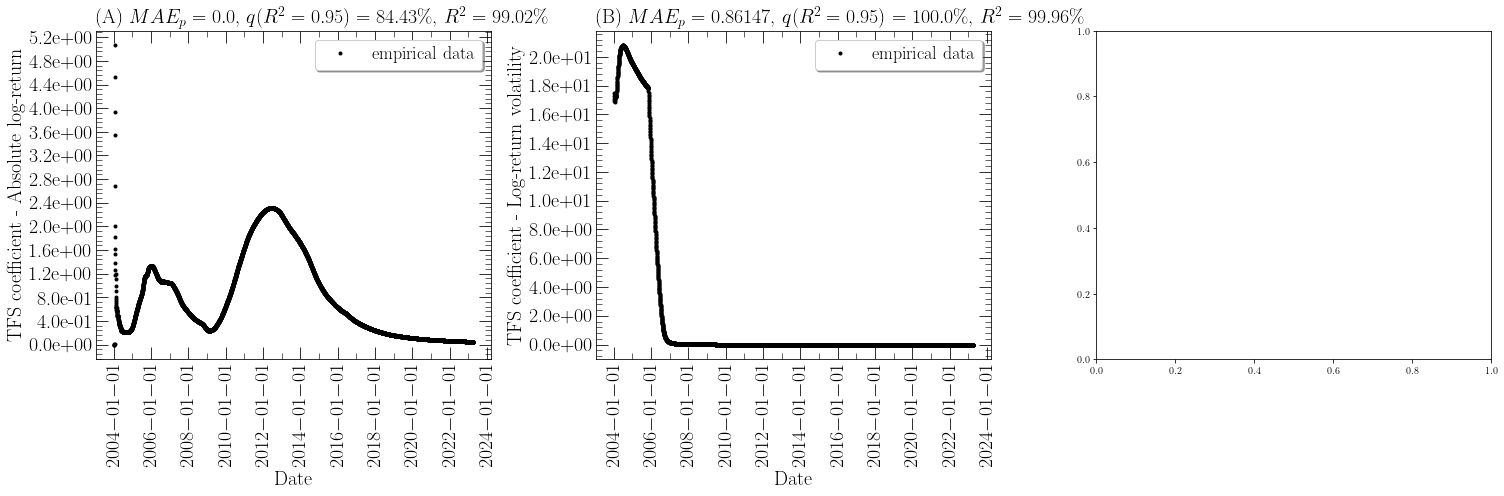

Generated plot for CHFUSD=X and time series absolute log-return
Generated plot for CHFUSD=X and time series log-return
Generated plot for CHFUSD=X and time series log-return volatility


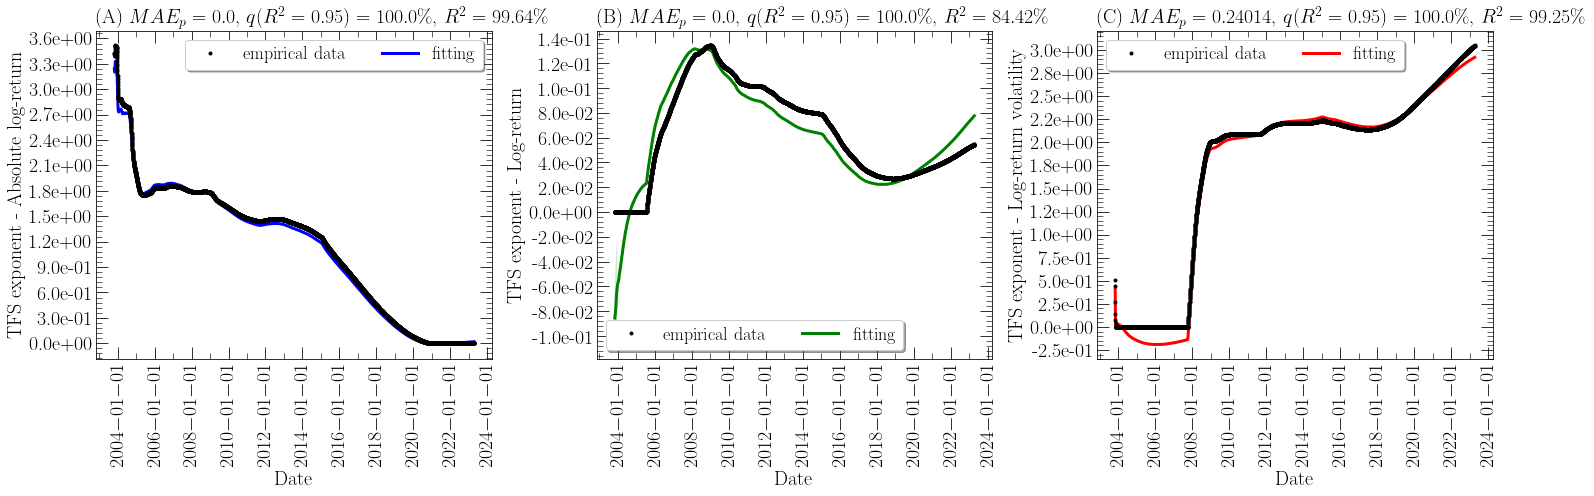

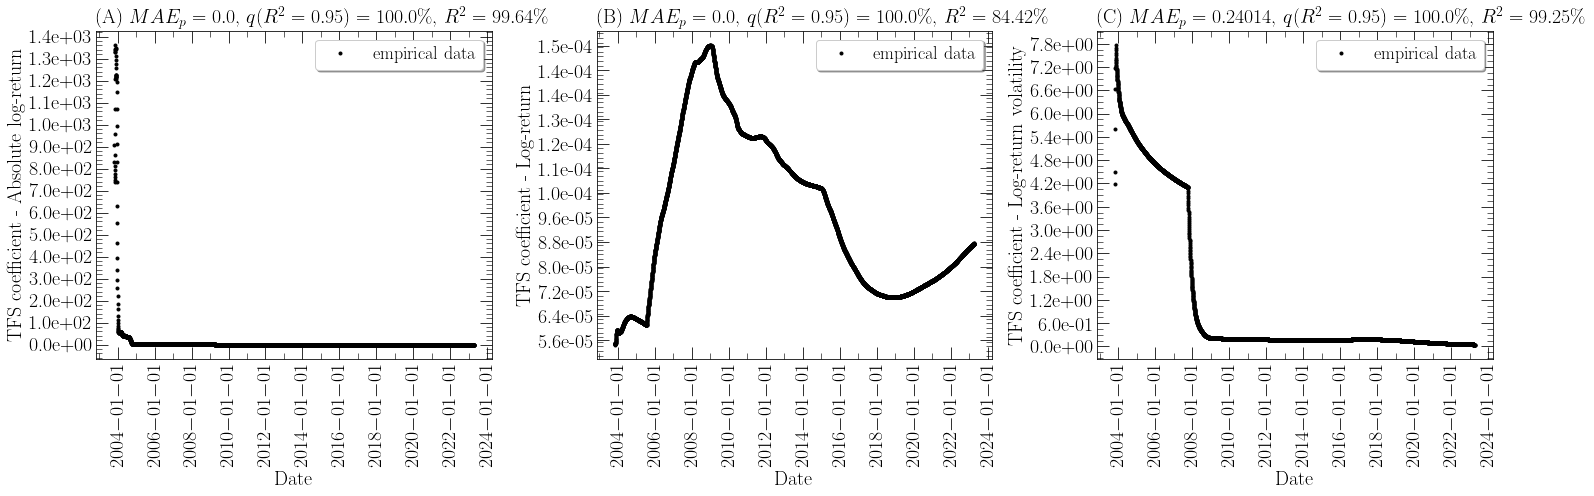

Generated plot for EURUSD=X and time series absolute log-return
Generated plot for EURUSD=X and time series log-return volatility


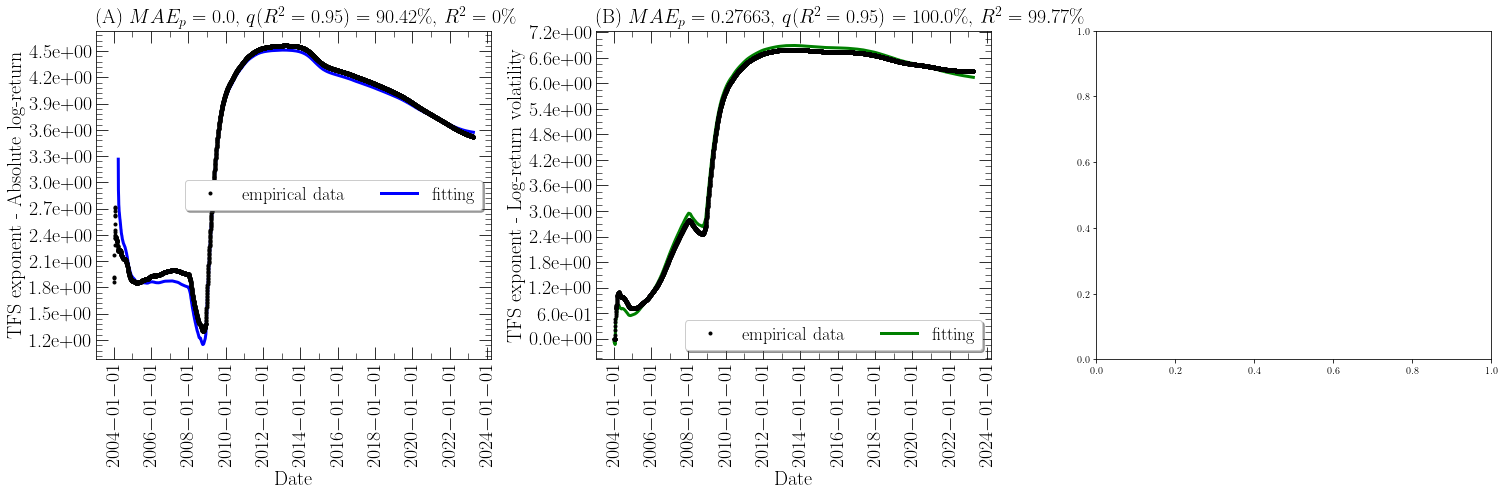

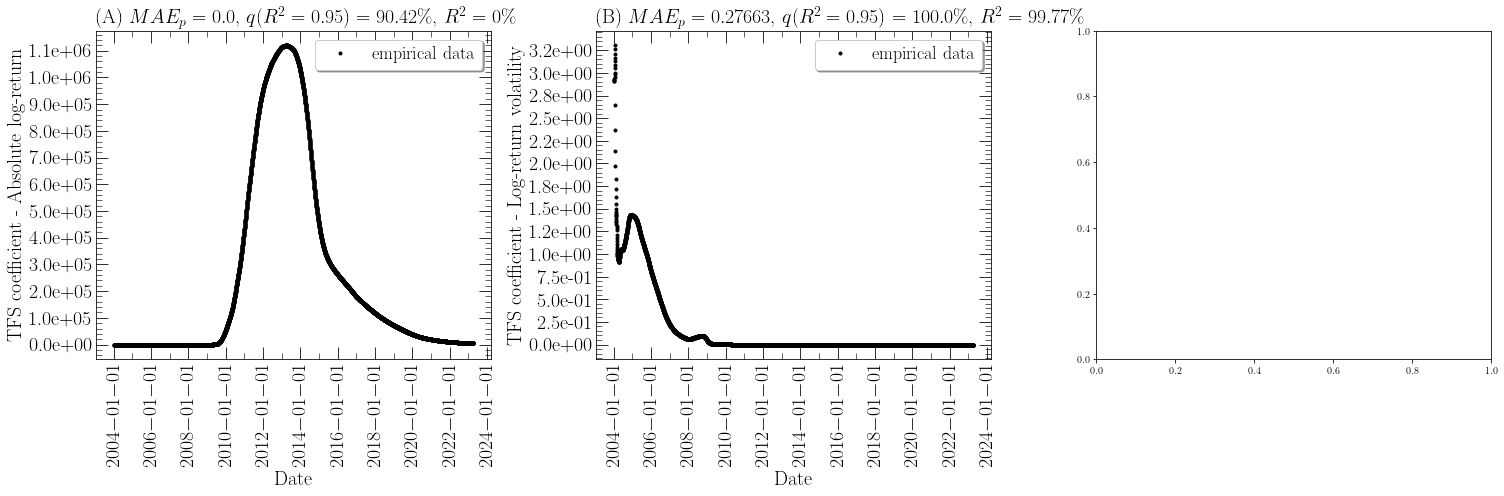

In [ ]:
for ticker, ticker_name in list_tickers.items():
    df_graph = plt_tfs.plot_tfs_evolution(
        df_fts = df_derivatives,
        df_optimal = df_optimal_derivatives_0,
        df_tfs = df_derivatives_tfs_parameters_0,
        interval = "days",
        threshold = 0.95,
        symbols = [ticker],
        width = 21,
        height = 7,
        all_data = True,
        markersize = 3,
        fontsize_labels = 20,
        fontsize_legend = 18,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 15,
        n_y_breaks = 15,
        fancy_legend = True,
        dpi = 900,
        save_figures = True,
        output_path = "{}/{}/aesepelt".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = "{}_0".format(re.sub("(\^)|(=X)", "", ticker)),
        input_generation_date = input_generation_date
    )